In [1]:
%%javascript
/** Below because this notebook is pretty large */
var rto = 500;
console.log('NB: Increase require timeout to ' + rto + ' seconds');
window.requirejs.config({waitSeconds: rto}); 


<IPython.core.display.Javascript object>

# Twitter Sentiment Analysis 

This is a Natural Language Processing (NLP) Project to perform sentiment analysis on Tweets about various products to determine the if the sentiment was positive, negative, or neutral. A successful model would prove valueable.

The challenge of Natural Language Processing is to handle how people actually write on Twitter - dealing with the many hurdles of abbreviation, misspellings, emojis, and other information in Tweets that can gum up a predictive model. A sentiment analyzer is able to 

# Business Problem 

"There is no such thing as bad press." The goal of this project is to work against that traditional idea. The dataset is Tweets from 2011 South by Southwest where the iPad 2 was launched by Apple. There are negative, positive, and neutral sentiment Tweets. To borrow a phrase, the goal is to find "The Haters," the critics and complainers. If in a given time those users can be reached, perhaps a savy PR team can quel a spark before it becomes a full on fire. An on the spot Sentiment Analyzer would be able to intake tweets and find which Tweets belong to the negative class.

This could be employed in an ongoing fashion, or be deployed for specific events like conferences, festivals, and other events. A company launching a new product, a political candidate attempting a new messaging slogan, or a band dropping a new album could supplement the efforts of the social media manager to find negative sentiment before it spreads.

## Project Metrics

The business problem for this project guides the metrics to that recall for negative tweets without abandoning precision of the negative tweets. For the purposes of this project positive and neutral sentiment will be grouped together, though during EDA I will examine positive and neutral sentiment to glean other insights about the language used. 

Trying to capture as many negative tweets as possible, without leading to false positive identification of negative tweets is important to maintaining a balanced metric so I may employ a F-Beta scorer during optimization. I will have to handle the imbalance of this dataset, happily for the stake holders a minority of the Tweets are negative, however for model training this can be a problem.

In [2]:
#Basic Imports
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', 0)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [4]:
#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
#Natural Language Toolkit Imports
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
import nltk

In [6]:
#text imports
import json
import re
from bs4 import BeautifulSoup
import contractions
import num2words
import string

In [7]:
from Helpers import functions as fn

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/seanyboy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Initial Data Exploration

### Data Set`

In [8]:
#Problems with errors, using ignore parameter
with open('Data/judge-1377884607_tweet_product_company.csv', encoding='UTF8', errors='ignore') as f:
    data = pd.read_csv(f)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [10]:
data[data['tweet_text'].isnull()]

tweet_text emotion_in_tweet_is_directed_at  \
6  NaN        NaN                              

  is_there_an_emotion_directed_at_a_brand_or_product  
6  No emotion toward brand or product

In [11]:
#Dropping Null Tweet
data.drop(6,inplace=True)

In [12]:
data.sample(50)

tweet_text  \
182   Behind on 100s of emails? Give them all 1 line iPhone composed replies. #SXSW #protip                                                                
1778  The iPad 2 goes on sale next Friday...the Austin Apple Store is going to be busy! #SXSW                                                              
144   Anyone at #sxsw been by the pop-up Apple store in Austin? That's gotta be a hopping place today.                                                     
8439  Watching the iPad-made movie at #busy makes me wish I was at whatever party they were at when they made it instead of... here. #SXSW                 
8582  Google Hotpot at #sxsw - instant rating &amp; review via Places, social sharing, etc. Yelp killer?                                                   
8809  Don't know 1 user RT @mention Who uses Google TV in this room? Nobody raises a hand in a packed room at the #socialviewing session at #sxsw          
7904  Maybe this strange Google logo from last autumn was an obscure hint about Google Circles {link} #sxsw                                                
5532  RT @mention Australian business &amp; not-for-profits may be interested in these SEO insights from Google &amp; Bing at #sxsw {link} #digibiz        
8047  Adloopz: Social Media Advertising done the easy way. Visit www.adloopz.com  #SXSW #sxswi #ipad                                                       
8030  Forget disneyland... the apple pop-up store in austin is the happiest place on earth #SXSW                                                           
7415  Pop-up Apple Store for #SXSW. (@mention Apple Store, SXSW w/ 86 others) [pic]: {link}                                                                
2816  Just passed a homeless w a sign: 'Saving for Ipad 2' #sxsw                                                                                           
6870  RT @mention Was intending to bring my trusty backpack for this upcoming trip to #SXSW. With the number of iPad 2s I'm helping b ...                  
5650  RT @mention Cunning Apple, keeping the #iPad2 popup store open late next to #sxsw parties for impulsive lat_ (cont) {link}                           
2812  Why the heck would anyone want Mozilla to switch to CrapKit (WebKit) when Gecko is good? Stupid Apple/Google bandwaggoners. #sxsw                    
8040  Google's social feature, CIRCLES, to be presented today at #SXSW today. Privacy and Open Source Focus rumor says - {link}                            
7454  Report: Apple to Open Pop-Up Store at #SXSW                                                                                                          
1595  Nice. RT @mention Hey, Apple fans! Get a peek at the space that's slated to be a pop-up #SXSW Apple Store tomorrow: {link}                           
4898  Earlier today: A story about a guy named Shawn Blanc {link} #mac #apple #sxsw cc: @mention                                                           
3086  &quot;Something Ventured&quot; is great. It has some great stories in it including Genentech, Apple, and Cisco. #sxsw                                
1270  If you're trying to contact friends or family in #Japan, @mention has created a person finder: {link} #SXSW                                          
581   @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw۝ te dije wey @mention                                 
6443  RT @mention Perfect #SXSW iPhone app home screen organization: {link} (I like it)                                                                    
6258  RT @mention listening to @mention discuss new interaction paradigms in designing for the ipad #uxdes #sxsw                                           
8021  I7: Releasing the Demons {link} [codes valid: 4:00-7:59:59p 03/11/11] #infektd #sxsw #zomb                                                           
6805  RT @mention To all our #SXSW friends, don't forget to download the #SXSWGO iPhon

In [13]:
data.head(50)

tweet_text  \
0   .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.                               
1   @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW                   
2   @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                                               
3   @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                                            
4   @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)                           
5   @teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd                  
7   #SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan                    
8   Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB                             
9   Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear                                                                      
10  Excited to meet the @samsungmobileus at #sxsw so I can show them my Sprint Galaxy S still running Android 2.1.   #fail                                        
11  Find &amp; Start Impromptu Parties at #SXSW With @HurricaneParty http://bit.ly/gVLrIn I can't wait til the Android app comes out.                             
12  Foursquare ups the game, just in time for #SXSW http://j.mp/grN7pK) - Still prefer @Gowalla by far, best looking Android app to date.                         
13  Gotta love this #SXSW Google Calendar featuring top parties/ show cases to check out.  RT @hamsandwich via @ischafer =&gt;http://bit.ly/aXZwxB                
14  Great #sxsw ipad app from @madebymany: http://tinyurl.com/4nqv92l                                                                                             
15  haha, awesomely rad iPad app by @madebymany http://bit.ly/hTdFim #hollergram #sxsw                                                                            
16  Holler Gram for iPad on the iTunes App Store -  http://t.co/kfN3f5Q (via @marc_is_ken) #sxsw                                                                  
17  I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone                              
18  Just added my #SXSW flights to @planely. Matching people on planes/airports. Also downloaded the @KLM iPhone app, nicely done.                                
19  Must have #SXSW app! RT @malbonster: Lovely review from Forbes for our SXSW iPad app Holler Gram - http://t.co/g4GZypV                                        
20  Need to buy an iPad2 while I'm in Austin at #sxsw. Not sure if I'll need to Q up at an Austin Apple store?                                                    
21  Oh. My. God. The #SXSW app for iPad is pure, unadulterated awesome. It's easier to browse events on iPad than on the website!!!                               
22  Okay, this is really it: yay new @Foursquare for #Android app!!!!11 kthxbai. #sxsw                                                                            
23  Photo: Just installed the #SXSW iPhone app, which is really nice! http://tumblr.com/x6t1pi6av7                                                                
24  Really enjoying the changes in Gowalla 3.0 for Android! Looking forward to seeing what else they &amp; Foursquare have up their sleeves at #SXSW              
25  RT @LaurieShook: I'm looking forward to the #SMCDallas pre #SXSW party

In [14]:
data.tail(50)

tweet_text  \
9043  Hey is anyone doing #sxsw signing up for the group texting app, groupme? got it on my iphone, but no one else is on it, so....kinda useless.             
9044  Look everyone! Zomg @mention got an iPad 2 on the first day! #sxsw {link}                                                                                
9045  @mention you are my favorite-- thanks for coming to @mention -- when you getting an iPhone again?? #SXSW                                                 
9046  you know you are on the plane to #SXSW when u become Facebook friends with your seatmate. He added me on his iPad, I added him on my laptop              
9047  Those of you at #SXSW I need the details on Google Circle! What's it all about? @mention @mention                                                        
9048  @mention You bet man! Kindle and Apple for sure. You can pre-order on Amazon. You at #SXSW?                                                              
9049  @mention you can buy my used iPad and I'll pick one up tomorrow ;-) #sxsw                                                                                
9050  @mention you can check out {link} for other #SXSW iPad apps too.                                                                                         
9051  @mention You can get an iPad 1 for under $350 now. And they'll be $99 before you know it. Look at iPhone. #newsapps #sxsw                                
9052  @mention You could buy a new iPad 2 tmrw at the Apple pop-up store at #sxsw: {link}                                                                      
9053  @mention you could win a #sony Xperia play before you can buy it later today at #SXSW details here #android                                              
9054  Guys, if you ever plan on attending #SXSW, you need 4 things, skinny jeans, flannel shirt, beard and an iPad #imanoutcast...                             
9055  @mention you give away that iPad yet.... ? #sxsw                                                                                                         
9056  @mention you going to #Google announcement @mention #SXSW today? would love your realtime reaction to #Circles. {link}                                   
9057  @mention You guys should do this &amp; give me the iPad you win :) &quot;@mention CBS, SCVNGR Launch Spy Game at SXSW - {link} #sxsw&quot;               
9058  &quot;Do you know what Apple is really good at? Making you feel bad about your Xmas present!&quot; - Seth Meyers on iPad2 #sxsw #doyoureallyneedthat?    
9059  @mention you know...they sell apple products at places other than #sxsw... just sayin.                                                                   
9060  @mention you might also appreciate new iPhone app tweetcaster. Zip it feature let's you hide ANY keywords or hashtag, incl of course #sxsw :)            
9061  @mention You realize I'm still padless? I just gave away a case at #bmm with @mention - need to win the next iPad first. #sxsw                           
9062  @mention you should find @mention or...you can go purchase the new ipad2 at the #sxsw apple kiosk                                                        
9063  @mention You should get the iPad 2  to save your back from lugging the laptop #SXSW #SXSWMyMistake                                                       
9064  @mention you should see the line here at #SXSW in front of the Apple store. Nothing like a tech geek gathering on launch day.                            
9065  Soooo do you think Apple will have a mobile store for iPad sales at #SXSW on Friday?!?! @mention @mention @mention @mention ;)                           
9066  How much you want to bet Apple is disproportionately stocking the #SXSW pop-up store with iPad 2? The influencer/hipsters thank you                      
9067  &quot;If you were able to afford to attend  #sxsw or buy an #iPad today, consider saving a few $$$ for #Japan #earthquake relief. #Justsayin

A manual look at the dataframe so the challenges that lay ahead, much of the key to modeling will be preprocessing in order to work through the model. There are some choices that will need to be made and also some general solutions.

### Rename Columns

In [15]:
#Renaming Columns to shorter names
names = {'emotion_in_tweet_is_directed_at': 'Product',
        'is_there_an_emotion_directed_at_a_brand_or_product': 'Sentiment'}
data.rename(columns=names,
          inplace=True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  9092 non-null   object
 1   Product     3291 non-null   object
 2   Sentiment   9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


### Target Breakdown

In [17]:
data['Sentiment'].value_counts(normalize=True)

No emotion toward brand or product    0.592609
Positive emotion                      0.327541
Negative emotion                      0.062692
I can't tell                          0.017158
Name: Sentiment, dtype: float64

<AxesSubplot:>

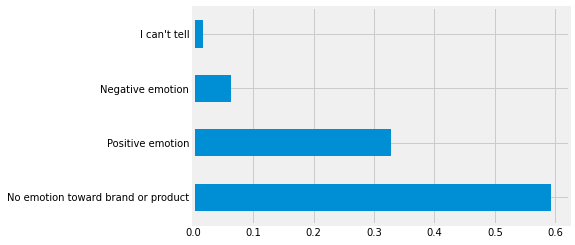

In [18]:
plt.style.use('fivethirtyeight')
data['Sentiment'].value_counts(normalize=True).plot.barh()

As stated previously this is a massively imbalanced dataset, with neutral or no emotions dominating the dataset, negative tweets make up a scant 6 percent of all observations. I will adjust for this imbalance and also seek additional examples to help in the modeling process.

I will replace the labels with shorter strings.

In [19]:
data['Sentiment']=data['Sentiment'].str.replace('No emotion toward brand or product','Neutral')

In [20]:
data['Sentiment']=data['Sentiment'].str.replace('Positive emotion','Positive')

In [21]:
data['Sentiment']=data['Sentiment'].str.replace('Negative emotion','Negative')

### Product Category Nulls

In [22]:
data[data['Product'].isna()]['Sentiment'].value_counts(normalize=True)

Neutral         0.913118
Positive        0.052750
I can't tell    0.025340
Negative        0.008792
Name: Sentiment, dtype: float64

In [23]:
np.sum(data['Product'].isna())

5801

There are 5801 nulls in the product category, these are not neccesary for modeling but would help for overall insight, so I will attempt to label as many of the nulls as possible, but it will not affect modeling. 

In [24]:
data[data['Sentiment']=="I can't tell"]['Product'].value_counts()

iPad                               4
Apple                              2
Google                             1
Other Google product or service    1
iPhone                             1
Name: Product, dtype: int64

In [25]:
data[data['Sentiment']=="I can't tell"]

tweet_text  \
90    Thanks to @mention for publishing the news of @mention new medical Apps at the #sxswi conf. blog {link} #sxsw #sxswh                                    
102   @mention &quot;Apple has opened a pop-up store in Austin so the nerds in town for #SXSW can get their new iPads. {link} #wow                            
237   Just what America needs. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw                              
341   The queue at the Apple Store in Austin is FOUR blocks long. Crazy stuff! #sxsw                                                                          
368   Hope it's better than wave RT @mention Buzz is: Google's previewing a social networking platform at #SXSW: {link}                                       
...                                                                                                                 ...                                       
9020  It's funny watching a room full of people hold their iPad in the air to take a photo. Like a room full of tablets staring you down. #SXSW               
9032  @mention yeah, we have @mention , Google has nothing on us :) #SXSW                                                                                     
9037  @mention Yes, the Google presentation was not exactly what I was expecting. #sxsw                                                                       
9058  &quot;Do you know what Apple is really good at? Making you feel bad about your Xmas present!&quot; - Seth Meyers on iPad2 #sxsw #doyoureallyneedthat?   
9066  How much you want to bet Apple is disproportionately stocking the #SXSW pop-up store with iPad 2? The influencer/hipsters thank you                     

     Product     Sentiment  
90    NaN     I can't tell  
102   NaN     I can't tell  
237   NaN     I can't tell  
341   NaN     I can't tell  
368   NaN     I can't tell  
...   ...              ...  
9020  NaN     I can't tell  
9032  NaN     I can't tell  
9037  NaN     I can't tell  
9058  NaN     I can't tell  
9066  Apple   I can't tell  

[156 rows x 3 columns]

In [26]:
len(data[data['Sentiment']=="I can't tell"])

156

In [27]:
#Dropping Unclear Sentiment Examples
data = data[data['Sentiment']!="I can't tell"].copy()

In [28]:
data['Sentiment'].value_counts(normalize=True)

Neutral     0.602954
Positive    0.333259
Negative    0.063787
Name: Sentiment, dtype: float64

This is still very imbalanced, but we can dig into the null values in the product category to help sort some of this out.

In [29]:
data[data['Product'].isna()]['Sentiment'].value_counts(normalize=True)

Neutral     0.936859
Positive    0.054121
Negative    0.009020
Name: Sentiment, dtype: float64

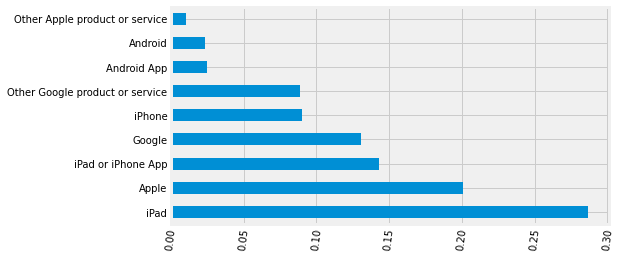

In [30]:
plt.figure(figsize=(7,4))
data['Product'].value_counts(normalize=True).plot.barh()
plt.xticks(rotation = 83);

Let's Dive into some tweet examples

### Tweet Examples 

In [31]:
poz_samples = data[data['Sentiment']=='Positive'].sample(n=5)

In [32]:
poz_samples

tweet_text  \
3175  Platform for Concertgoers Launches Android App in Time for SXSW - Mashable! {link} #sxsw                                                              
4872  Excited to see this! RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw                                
4785  +1 RT @mention Love it. @mention #sxsw: &quot;apple comes up with cool technology no one's ever heard of because they don't go to conferences&quot;   
101   Headline: &quot;#iPad 2 is the Must-Have Gadget at #SXSW&quot; Hmm... I could have seen that one coming! {link} #gadget                               
1544  @mention @mention @mention &quot;@mention Google to Launch Major New Social Network: Circles, Possibly Today {link}  #sxsw&quot;                      

                              Product Sentiment  
3175  Android App                      Positive  
4872  Other Google product or service  Positive  
4785  Apple                            Positive  
101   iPad                             Positive  
1544  Other Google product or service  Positive

It will be good to randomly show given examples of tweet sentiments to see if they are properly labeled.

In [33]:
def show_random(data,sentiment,num_tries=5,num_samps=5):
    for x in range(num_tries):
        print(f'Sampling {x} of {num_tries}')
        samples = data[data['Sentiment']==sentiment].sample(n=num_samps)
        index = list(samples.index)
        for x in index:
            print(x)
            print(samples['tweet_text'][x])
            print('-----')
    

In [34]:
show_random(data,'Positive')

Sampling 0 of 5
6966
RT @mention Wonder when Google's #impactdashboard (being demoed now) will become part of Google Analytics #bavcid #SXSW
-----
1853
Free portable iPhone charger from @mention I'm about to use the heck out of this at #SXSW. {link}
-----
5956
RT @mention Guys, if you ever plan on attending #SXSW, you need 4 things, skinny jeans, flannel shirt, beard and an iPad #imanoutcast...
-----
8490
Still waiting for someone to stop by with the new iPad 2 and my game on it. The prize is waiting for you!  #SXSW
-----
2826
I connected my bluetooth keyboard to my iPhone! Hello fast blogging while I'm at #SXSW
-----
Sampling 1 of 5
4432
I think an iPad is eminent. Typing thoughtful notes on a phone not working,  mac book to big, handwriting is ridic. #sxsw day 2 conquered.
-----
4061
At Josh Clark's #sxsw session on iPad/tablet development. First note, iPad more of a leisure/planning/restful device. #tapworthy #webvisions
-----
7614
Apple store coming 2 Austin for SXSW.   RT: &quot;@

In [35]:
show_random(data,'Negative')

Sampling 0 of 5
8712
Just because google patented something i.e. (Age of domain in rankings algorithm) doesn't mean they use it #qagb #SXSW
-----
3981
First talk of the day : iPad design headaches. #SXSW
-----
3552
@mention I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw
-----
2027
Is there any way of deleting an app that won't stop loading on the iPhone? Draining my power, but no 'x' to cancel. Help me, #SXSW.
-----
6344
RT @mention New #SXSW rule: no more ooing and ahing over your new iPad. We get it. Its not a big deal. Everybody has one now... :-)
-----
Sampling 1 of 5
6265
RT @mention Lonely Planet releases free Austin city guide iPhone app for #SXSW. Like there aren't enough apps cluttering up your handset.
-----
6164
RT @mention Ironic? I googled the directions to @mention party and ended up walked 6 blocks in the wrong direction. Time for bed I think. #SXSW
-----
1355
@mention - #Apple is the classiest fascist company in America. Really elegant. #sx

I will say a glance looking at some of these tweets reveals some problem with the labeling of the sentiment. Some of the tweets that are labeled negative about a specific product are not actually targeting the product in question, but rather a situation or person.

Maybe any press is bad press! So it's helpful to see the light that the products are being talked about even if it's not that product being targeted specifically. 

In [36]:
show_random(data,'Neutral')

Sampling 0 of 5
8701
Record your #sxsw experience with your iPhone.
{link}
-----
195
Having my 2nd cocktail &quot;Texas Snowflake&quot;  ( @mention google it!!) at the #CNNGrill #SxSw
-----
4726
Apple opens #sxsw pop-up store in Austin, TX - {link}
-----
8311
At Protect your privacy like it's 2011 @mention party w/ @mention &amp; @mention #sxsw
-----
5993
RT @mention Hey @mention do you have an iPhone? We'd love to turn your art into a iPhone case. Let us know! #zazzlesxsw #sxsw
-----
Sampling 1 of 5
2958
{link} @mention new mobile app. Your store circulars via Android Blackberry iOS Even Austin &amp; #SXSW {link}
-----
7704
No. Confirmed RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw
-----
7437
@mention power struggles in the internet industry boil down to &quot;who is the platform &amp; who is the app?&quot; see Facebook on iPad. #sxsw
-----
6601
RT @mention RT @mention RT @mention #SXSW a line of about 100 outside Apple pop- up stor

The sentiments appear to be labeled correctly, there did appear to be a neutral tweet that I would consider to be postive, it would be good to do a descriptive dive into the labeling to see what percentage of random samples are properly labeled and which are not. 

## Additional Negative Examples

I was able to find an additional examples from crowd flower for for additional negative examples of tweets. I will experiment with possibly using these examples as well to help with the problem of imbalanced data. This is a dataset pertaining to Apple stock price and the effect of tweets on predicting stock price movement.

In [37]:
new_data = pd.read_csv('Data/Apple-Twitter-Sentiment-DFE.csv',encoding='Latin1')

In [38]:
new_data['sentiment'].value_counts()

3               2162
1               1219
5               423 
not_relevant    82  
Name: sentiment, dtype: int64

In [39]:
new_data.head(20)

_unit_id  _golden _unit_state  _trusted_judgments _last_judgment_at  \
0   623495513  True     golden      10                  NaN                
1   623495514  True     golden      12                  NaN                
2   623495515  True     golden      10                  NaN                
3   623495516  True     golden      17                  NaN                
4   623495517  False    finalized   3                   12/12/14 12:14     
5   623495518  True     golden      13                  NaN                
6   623495519  True     golden      13                  NaN                
7   623495520  True     golden      9                   NaN                
8   623495521  True     golden      15                  NaN                
9   623495522  False    finalized   3                   12/12/14 0:52      
10  623495523  True     golden      12                  NaN                
11  623495524  True     golden      9                   NaN                
12  623495525  True     golden      11                  NaN                
13  623495526  False    finalized   3                   12/12/14 21:38     
14  623495527  True     golden      17                  NaN                
15  623495528  False    finalized   6                   12/12/14 15:50     
16  623495529  True     golden      16                  NaN                
17  623495530  False    finalized   3                   12/12/14 3:38      
18  623495531  False    finalized   3                   12/12/14 4:59      
19  623495532  False    finalized   3                   12/12/14 20:59     

       sentiment  sentiment:confidence                            date  \
0   3             0.6264                Mon Dec 01 19:30:03 +0000 2014   
1   3             0.8129                Mon Dec 01 19:43:51 +0000 2014   
2   3             1.0000                Mon Dec 01 19:50:28 +0000 2014   
3   3             0.5848                Mon Dec 01 20:26:34 +0000 2014   
4   3             0.6474                Mon Dec 01 20:29:33 +0000 2014   
5   3             0.5975                Mon Dec 01 20:30:03 +0000 2014   
6   5             0.8468                Mon Dec 01 20:32:45 +0000 2014   
7   5             0.6736                Mon Dec 01 20:34:31 +0000 2014   
8   3             0.7997                Mon Dec 01 20:36:47 +0000 2014   
9   3             0.6360                Mon Dec 01 20:45:03 +0000 2014   
10  1             1.0000                Mon Dec 01 20:46:01 +0000 2014   
11  3             0.6658                Mon Dec 01 20:47:12 +0000 2014   
12  3             0.8381                Mon Dec 01 21:00:15 +0000 2014   
13  5             1.0000                Mon Dec 01 21:03:32 +0000 2014   
14  1             1.0000                Mon Dec 01 21:09:50 +0000 2014   
15  3             0.4798                Mon Dec 01 21:29:45 +0000 2014   
16  1             0.9399                Mon Dec 01 21:35:14 +0000 2014   
17  not_relevant  0.6904                Mon Dec 01 21:52:04 +0000 2014   
18  3             0.6621                Mon Dec 01 21:53:12 +0000 2014   
19  3             1.0000                Mon Dec 01 22:22:09 +0000 2014   

              id            query   sentiment_gold  \
0   5.400000e+17  #AAPL OR @Apple  3\nnot_relevant   
1   5.400000e+17  #AAPL OR @Apple  3\n1              
2   5.400000e+17  #AAPL OR @Apple  3                 
3   5.400000e+17  #AAPL OR @Apple  3\n1              
4   5.400000e+17  #AAPL OR @Apple  NaN               
5   5.400000e+17  #AAPL OR @Apple  5                 
6   5.400000e+17  #AAPL OR @Apple  5                 
7   5.400000e+17  #AAPL OR @Apple  5\n3              
8   5.400000e+17  #AAPL OR @Apple  1                 
9   5.400000e+17  #AAPL OR @Apple  NaN               
10  5.400000e+17  #AAPL OR @Apple  1                 
11  5.400000e+17  #AAPL OR @Apple  5                 
12  5.400000e+17  #AAPL OR @Apple  3                 
13  5.400000e+17  #AAPL OR @Apple  NaN               
14  5.400000e+17  #AAPL OR @Apple  1       

In [40]:
#Renaming Columns to shorter names
names = {'query': 'Product',
        'sentiment': 'Sentiment','text':'tweet_text'}
new_data.rename(columns=names,
          inplace=True)

In [41]:
show_random(new_data,'1',5,5)

Sampling 0 of 5
3167
iPhone6 fell 2 ft. Screen shattered like it was blown up. @apple wants an additional $109 to fix it. Maybe make a product that lasts?
-----
3798
Dear Santa, All I want for Christmas is for @Apple to send my iPhone (ordered 9/29).
-----
1117
@Apple, Yosemite needs a lot more testing. Just hooked machine to Thunderbolt Display and was greeted with this. http://t.co/93qCPkJX9m
-----
2404
Frustrated after unsuccessfully trying to fix outgoing SMTP configuration. &lt;3 @Apple but this is unacceptable #YosemiteProblems #apple #help
-----
1982
RT @OneRepublic: Studio at 45,000 ft.  One outlet,  4 computers.  @Apple we need the batteries of the future NoW!!!! http://t.co/astp9x6KET
-----
Sampling 1 of 5
1515
RT @OneRepublic: Studio at 45,000 ft.  One outlet,  4 computers.  @Apple we need the batteries of the future NoW!!!! http://t.co/astp9x6KET
-----
782
@jakeflem @Apple We've previously had to deal with this issue it's really annoying. Try to reset the NVRAM http://t.co/

In [42]:
show_random(new_data,'3',5,5)

Sampling 0 of 5
3426
RT @TeamCavuto: Protesters stage #DieIn protests in @Apple store in NYC... Is it me, or is this anger misplaced? RETWEET if you agree.
-----
1101
We need an eye rolling emoji pronto @apple
-----
3568
#AAPL:In Their Own Words: Baidu's Robin Li On Xiaomi Founder Lei Jun's 'Guts...http://t.co/1lhPbkTPpF
-----
3500
RT @adage: Watch the weekend's new TV ads from @RadioShack, @Apple and more http://t.co/cKdkibI6PL
-----
2438
@Apple [#Apple] #Loop: #iPhone6S Rumors, #Steve Job's Garage Myth, iPhone 6C Speculation. (#Saturday, 6 #December) http://t.co/kZ27zJxqhf
-----
Sampling 1 of 5
12
The Best-Designed #iPhone #Apps In the World, According to @apple: http://t.co/Razqvpxofg http://t.co/ev7uKWiEcz
-----
3376
@TeamCavuto @Apple They're staging a die in ar an Apple store while being on their iPhone.
-----
1409
Rumor Roundup: Crescentgate-gate $AAPL #aapl
http://t.co/iQOYgnD72G
-----
3502
RT @abdinsyakirin: '@apple : Hey you wanna use iFon Siks? Jas follow @rizalscandal and u

In [43]:
show_random(new_data,'5',5,5)

Sampling 0 of 5
2005
@AppleOfficialll @apple I can't say enough about how awesome Apple has been. They've already processed a reorder for the phone that UPS lost
-----
947
@sashametro @mayhembcn @apple happy to help..if u use kind words :). Using apple process is free and fast. http://t.co/qQGQokjaxE. DM with ?
-----
2131
RT @shannonmmiller: Love the @Apple is supporting #HourOfCode with workshops! :) http://t.co/WP8D0FNjNu
-----
1190
I'm happy now, thnx fags. @apple
-----
1626
@OneRepublic @Apple awsome
-----
Sampling 1 of 5
1804
@OneRepublic @Apple aww look tht u have a lot of work guys good luck!
-----
2589
Thank you @apple #AppleSantaMonica for fixing my friend's phone in less than 2 hours free of charge. You guys are the best.
-----
1745
Yay @Apple customer support was super nice and helpful and now my iMessages is verified.
-----
156
Even With Apple Watch Delayed, I'm Raising My AAPL Price Target To $165 - http://t.co/TGENjFl3zI #AAPL #Alex_Cho
-----
407
CNBCTV:  #Apple arguably 

Similary this dataset is grouped with numeric sentiments. '1' labels are negative, '3' is neutral with some subjective disagreement, and '5' is positive. These tweets are from a dataset trying to find sentiment regarding Apple stock price, I will use the negative tweets to potentially augment the lack of negative examples in the dataset. 

In [44]:
neg_df = new_data[new_data['Sentiment']=='1'].copy()

In [45]:
neg_df=neg_df[['Product','Sentiment','tweet_text']].copy()

In [46]:
neg_df.columns

Index(['Product', 'Sentiment', 'tweet_text'], dtype='object')

In [47]:
data.columns

Index(['tweet_text', 'Product', 'Sentiment'], dtype='object')

In [48]:
neg_df['Sentiment']=neg_df['Sentiment'].str.replace('1','Negative')

In [49]:
neg_df['Product']=neg_df['Product'].str.replace('#AAPL OR @Apple','Apple')

In [50]:
neg_df.head(5)

Product Sentiment  \
10  Apple   Negative   
14  Apple   Negative   
16  Apple   Negative   
23  Apple   Negative   
24  Apple   Negative   

                                                                                                                                      tweet_text  
10  WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW IS 29% WTF IS THIS @apple                                                                       
14  @apple Contact sync between Yosemite and iOS8 is seriously screwed up. It used to be much more stable in the past. #icloud #isync             
16  WARNING IF YOU BUY AN IPHONE 5S UNLOCKED FROM @APPLE IPHONE YOU CANNOT USE IT ON VERIZON NETWORK                                              
23  @Apple, For the love of GAWD, CENTER the '1'on the damn calendar app. You fixed it once, its back, off center, AGAIN! http://t.co/dMyAHEm1Lc  
24  i get the storage almost full notification literally every 5 minutes chill @apple

In [51]:
new_data = pd.concat([data,neg_df]).reset_index()

In [52]:
new_data.drop('index',axis=1,inplace=True)

In [53]:
new_data['Sentiment'].value_counts(normalize=True)

Neutral     0.530576
Positive    0.293255
Negative    0.176169
Name: Sentiment, dtype: float64

In [54]:
new_data.to_csv('additional_negs',index=False)

I've created a new dataframe that adds substantially more negative examples, it is at the sacrifice of having data from the original data source, the benefits of a model that can better understand negative examples will be beneficial

We will be able to use the same transformers on this new dataset for modeling, it may potentially offer better scores.

### Sentiment by Product

<AxesSubplot:ylabel='Product'>

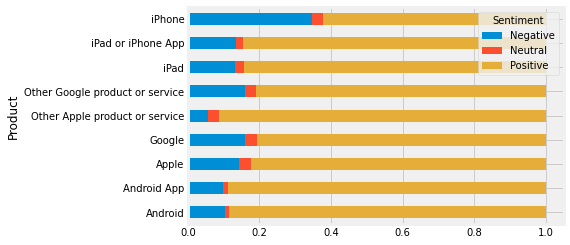

In [55]:
data.groupby('Product')['Sentiment'].value_counts(normalize=True, sort=False).unstack(1).sort_index(axis=1, ascending=True).plot.barh(stacked=True)

A look at a groupby with normalized value counts for the sentiment anlysis of the dataset shows bit of a surprise (to me at least) that iPhone has the highest negative emotion and lowest positive emotion. It is important to remember there are many more examples of iPhones in the Dataset, so it may be valueable to run a statistical test for understanding the validity here, but it is still noteworthy.

In [56]:
#Remove this character in particular
data['tweet_text']=data['tweet_text'].str.replace('۝','')

<AxesSubplot:ylabel='Product'>

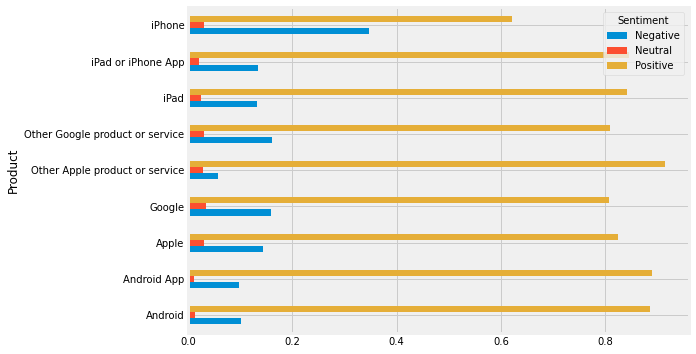

In [57]:
data.groupby('Product').Sentiment.value_counts(normalize=True).unstack(1).plot.barh(figsize=(8,6))

In [58]:
data['Product']

0       iPhone            
1       iPad or iPhone App
2       iPad              
3       iPad or iPhone App
4       Google            
         ...              
9088    iPad              
9089    NaN               
9090    NaN               
9091    NaN               
9092    NaN               
Name: Product, Length: 8936, dtype: object

<AxesSubplot:>

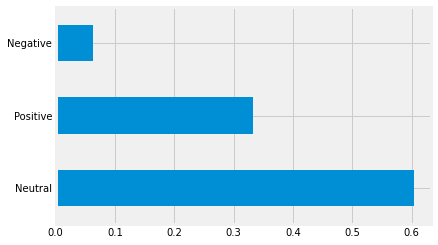

In [59]:
data['Sentiment'].value_counts(normalize=True).plot.barh()

Overwhelming the dataset's targets show a neutral sentiment towards the products they are talking about. It will be worth taking an eyeball look at what constitutes the sentiment, but it terms of model metrics we have a dataset that shows way more positive cases than negative cases - an unbalanced dataset which will have to be accounted for in the modeling process.

## Product Column Work

### Null Values in Product Column

In [60]:
np.sum(data.isna())

tweet_text    0   
Product       5654
Sentiment     0   
dtype: int64

The dataset unfortuneatly features many null values in the product column. This is unfortunate as it makes up over half the dataset.  

In [61]:
data[data['Product'].isna()]['Sentiment'].value_counts(normalize=True)

Neutral     0.936859
Positive    0.054121
Negative    0.009020
Name: Sentiment, dtype: float64

In [62]:
data['Sentiment'].value_counts(normalize=True)

Neutral     0.602954
Positive    0.333259
Negative    0.063787
Name: Sentiment, dtype: float64

In [63]:
counts = data['Product'].value_counts(dropna=False)
product_words = data[data['Product'].map(counts)>35]['Product'].value_counts().index.tolist()

In [64]:
product_words
lower_product = [w.lower() for w in product_words]
product_words.extend(lower_product)

In [65]:
product_words

['iPad',
 'Apple',
 'iPad or iPhone App',
 'Google',
 'iPhone',
 'Other Google product or service',
 'Android App',
 'Android',
 'ipad',
 'apple',
 'ipad or iphone app',
 'google',
 'iphone',
 'other google product or service',
 'android app',
 'android']

Looking at the sentiment of the Products that we have values for versus the column without values shows a very different picture. I could impute the products for the Product column and attempt to create a more observations for training. 

### Mask to See Null Values in Product Column

In [66]:
na_mask = data.loc[:,'Product'].isna().copy()

In [67]:
display(len(data),len(data[na_mask]))

8936

5654

There are 5654 observations in this data set where the Product column is null. Of those 1297 contain iPad, 1020 Apple, 0 contain Ipad or iPhone App, 1463 contain Google, and 784 contain iPhone. Android or Android app is contained in 294 and 13 observations respectively. 

In [68]:
data

tweet_text  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.                     
1     @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW         
2     @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                                     
3     @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                                  
4     @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)                 
...                                                                                                                                   ...                 
9088  Ipad everywhere. #SXSW {link}                                                                                                                       
9089  Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link}  #google #circles                       
9090  Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev   
9091  Some Verizon iPhone customers complained their time fell back an hour this weekend.  Of course they were the New Yorkers who attended #SXSW.        
9092  ϡ_ʋ΋ҋ⋁__RT @mention Google Tests Check-in Offers At #SXSW {link}                                                                                    

                 Product Sentiment  
0     iPhone              Negative  
1     iPad or iPhone App  Positive  
2     iPad                Positive  
3     iPad or iPhone App  Negative  
4     Google              Positive  
...      ...                   ...  
9088  iPad                Positive  
9089  NaN                 Neutral   
9090  NaN                 Neutral   
9091  NaN                 Neutral   
9092  NaN                 Neutral   

[8936 rows x 3 columns]

In [69]:
#Creating a copy of the null product values to alter
Null_df=data.loc[na_mask].copy()

In [70]:
#Null Dataframe
Null_df

tweet_text  \
5     @teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd        
16    Holler Gram for iPad on the iTunes App Store -  http://t.co/kfN3f5Q (via @marc_is_ken) #sxsw                                                        
32    Attn: All  #SXSW frineds, @mention Register for #GDGTLive  and see Cobra iRadar for Android. {link}                                                 
33    Anyone at  #sxsw want to sell their old iPad?                                                                                                       
34    Anyone at  #SXSW who bought the new iPad want to sell their older iPad to me?                                                                       
...                                                                             ...                                                                       
9087  @mention Yup, but I don't have a third app yet. I'm on Android, any suggestions? #SXSW CC: @mention                                                 
9089  Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link}  #google #circles                       
9090  Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev   
9091  Some Verizon iPhone customers complained their time fell back an hour this weekend.  Of course they were the New Yorkers who attended #SXSW.        
9092  ϡ_ʋ΋ҋ⋁__RT @mention Google Tests Check-in Offers At #SXSW {link}                                                                                    

     Product Sentiment  
5     NaN     Neutral   
16    NaN     Neutral   
32    NaN     Neutral   
33    NaN     Neutral   
34    NaN     Neutral   
...   ...         ...   
9087  NaN     Neutral   
9089  NaN     Neutral   
9090  NaN     Neutral   
9091  NaN     Neutral   
9092  NaN     Neutral   

[5654 rows x 3 columns]

In [71]:
#
Null_df['new_col'] = (Null_df['tweet_text'].str.findall(f"({'|'.join(product_words)})").str.join(', ').replace('', np.nan))

In [72]:
Null_df['new_col'].value_counts()

Google                            1219
iPad                              736 
iPhone                            579 
Apple                             511 
google                            255 
                                 ...  
iPad, apple, iPad                 1   
iPad, iPad, Apple, Apple, iPad    1   
Google, iPhone                    1   
Google, ipad                      1   
Google, Android, Google           1   
Name: new_col, Length: 135, dtype: int64

In [73]:
Null_df['Product']=Null_df['new_col']
Null_df.drop('new_col',axis=1,inplace=True)

In [74]:
data.loc[na_mask,'Product']=Null_df.loc[:,'Product'].copy()

In [75]:
np.sum(data['Product'].isna())

806

In [76]:
np.sum(data.isna())

tweet_text    0  
Product       806
Sentiment     0  
dtype: int64

In [77]:
np.sum(data.isna())/len(data)

tweet_text    0.000000
Product       0.090197
Sentiment     0.000000
dtype: float64

In [78]:
data.Sentiment.value_counts(normalize=True)

Neutral     0.602954
Positive    0.333259
Negative    0.063787
Name: Sentiment, dtype: float64

In [79]:
np.sum(data.isna())

tweet_text    0  
Product       806
Sentiment     0  
dtype: int64

We now have greatly decreased the number of null values in the product column, but we have also increased increased the number of different products.

In [80]:
data['Product'].value_counts()

iPad                              1678
Google                            1648
Apple                             1170
iPhone                            875 
iPad or iPhone App                470 
                                 ...  
Google, iPhone                    1   
iPhone, Android, android          1   
iPad, iPad, Apple, Apple, iPad    1   
android, google                   1   
iPad, apple, iPad                 1   
Name: Product, Length: 138, dtype: int64

Some of these are rendundent products in the the row. I can reduce these my deleting the second product.

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8936 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  8936 non-null   object
 1   Product     8130 non-null   object
 2   Sentiment   8936 non-null   object
dtypes: object(3)
memory usage: 279.2+ KB


In [82]:
data['Product']

0       iPhone            
1       iPad or iPhone App
2       iPad              
3       iPad or iPhone App
4       Google            
         ...              
9088    iPad              
9089    google            
9090    Google            
9091    iPhone            
9092    Google            
Name: Product, Length: 8936, dtype: object

In [83]:
product_words

['iPad',
 'Apple',
 'iPad or iPhone App',
 'Google',
 'iPhone',
 'Other Google product or service',
 'Android App',
 'Android',
 'ipad',
 'apple',
 'ipad or iphone app',
 'google',
 'iphone',
 'other google product or service',
 'android app',
 'android']

In [84]:
data

tweet_text  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.                     
1     @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW         
2     @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                                     
3     @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                                  
4     @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)                 
...                                                                                                                                   ...                 
9088  Ipad everywhere. #SXSW {link}                                                                                                                       
9089  Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link}  #google #circles                       
9090  Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev   
9091  Some Verizon iPhone customers complained their time fell back an hour this weekend.  Of course they were the New Yorkers who attended #SXSW.        
9092  ϡ_ʋ΋ҋ⋁__RT @mention Google Tests Check-in Offers At #SXSW {link}                                                                                    

                 Product Sentiment  
0     iPhone              Negative  
1     iPad or iPhone App  Positive  
2     iPad                Positive  
3     iPad or iPhone App  Negative  
4     Google              Positive  
...      ...                   ...  
9088  iPad                Positive  
9089  google              Neutral   
9090  Google              Neutral   
9091  iPhone              Neutral   
9092  Google              Neutral   

[8936 rows x 3 columns]

In [85]:
not_na_mask = data.loc[:,'Product'].notna().copy()

In [86]:
data.loc[not_na_mask,'Product']

0       iPhone            
1       iPad or iPhone App
2       iPad              
3       iPad or iPhone App
4       Google            
         ...              
9088    iPad              
9089    google            
9090    Google            
9091    iPhone            
9092    Google            
Name: Product, Length: 8130, dtype: object

In [87]:
reduced_series = data.loc[not_na_mask,'Product'].map(lambda x: set(x.split(', ')))

In [88]:
reduced_series[100:150]

119    {Apple}                          
120    {Apple}                          
121    {iPad}                           
123    {iPhone}                         
124    {iPad or iPhone App}             
125    {ipad}                           
126    {iPad}                           
127    {iPad}                           
128    {iPad}                           
129    {Google}                         
131    {Google}                         
132    {Google}                         
133    {Apple}                          
134    {Apple}                          
135    {iPhone}                         
136    {Apple}                          
137    {Google}                         
138    {iPhone}                         
139    {iphone}                         
140    {iphone}                         
141    {Apple}                          
142    {iPad or iPhone App}             
143    {Apple}                          
144    {Apple}                          
145    {iPad or 

In [89]:
' '.join({'iPad', 'iPhone'})

'iPad iPhone'

In [90]:
data.loc[not_na_mask,'Product']=reduced_series

In [91]:
joined_series = data.loc[not_na_mask,'Product'].map(lambda x: ' '.join(x))

In [92]:
joined_series

0       iPhone            
1       iPad or iPhone App
2       iPad              
3       iPad or iPhone App
4       Google            
         ...              
9088    iPad              
9089    google            
9090    Google            
9091    iPhone            
9092    Google            
Name: Product, Length: 8130, dtype: object

In [93]:
data.loc[not_na_mask,'Product']=joined_series

### Reducing Product Value Counts

In [94]:
data

tweet_text  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.                     
1     @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW         
2     @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                                     
3     @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                                  
4     @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)                 
...                                                                                                                                   ...                 
9088  Ipad everywhere. #SXSW {link}                                                                                                                       
9089  Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link}  #google #circles                       
9090  Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev   
9091  Some Verizon iPhone customers complained their time fell back an hour this weekend.  Of course they were the New Yorkers who attended #SXSW.        
9092  ϡ_ʋ΋ҋ⋁__RT @mention Google Tests Check-in Offers At #SXSW {link}                                                                                    

                 Product Sentiment  
0     iPhone              Negative  
1     iPad or iPhone App  Positive  
2     iPad                Positive  
3     iPad or iPhone App  Negative  
4     Google              Positive  
...      ...                   ...  
9088  iPad                Positive  
9089  google              Neutral   
9090  Google              Neutral   
9091  iPhone              Neutral   
9092  Google              Neutral   

[8936 rows x 3 columns]

In [95]:
data['Product'].value_counts()

Google                1759
iPad                  1732
Apple                 1210
iPhone                888 
iPad or iPhone App    470 
                     ...  
Apple google          1   
apple iPhone          1   
Google iphone ipad    1   
iPad iPhone Apple     1   
Android ipad          1   
Name: Product, Length: 64, dtype: int64

In [96]:
data['Product'].value_counts(normalize=True)

Google                0.216359
iPad                  0.213038
Apple                 0.148831
iPhone                0.109225
iPad or iPhone App    0.057811
                        ...   
Apple google          0.000123
apple iPhone          0.000123
Google iphone ipad    0.000123
iPad iPhone Apple     0.000123
Android ipad          0.000123
Name: Product, Length: 64, dtype: float64

This has reduced string repetition greatly, but there are still cases where there are multiple products or a company's product that is a problem in the dataset. I have put effort into salvaging observations in the dataset that could've been labeled with actual products into set of being set to Nan as they were before. Looking at the value counts I can set a threshold of 1% and save a lion share of data without having to spend more time on preprocessing. 

First iPad has its own large percentage of observations, so the "iPad Apple" values can be encoded as "iPad"

In [97]:
#Using .loc to change 'iPad Apple' to 'iPad'
data.loc[data['Product']=='iPad Apple','Product']='iPad'

In [98]:
data['Product'].value_counts(normalize=True)

iPad                  0.252645
Google                0.216359
Apple                 0.148831
iPhone                0.109225
iPad or iPhone App    0.057811
                        ...   
Apple google          0.000123
apple iPhone          0.000123
Google iphone ipad    0.000123
iPad iPhone Apple     0.000123
Android ipad          0.000123
Name: Product, Length: 63, dtype: float64

In [99]:
data.loc[data['Product']=='Android App','Product']='Android'

In [100]:
display(
data['Product'].value_counts(normalize=True),
data['Product'].value_counts())

iPad                  0.252645
Google                0.216359
Apple                 0.148831
iPhone                0.109225
iPad or iPhone App    0.057811
                        ...   
Apple google          0.000123
apple iPhone          0.000123
Google iphone ipad    0.000123
iPad iPhone Apple     0.000123
Android ipad          0.000123
Name: Product, Length: 62, dtype: float64

iPad                  2054
Google                1759
Apple                 1210
iPhone                888 
iPad or iPhone App    470 
                     ...  
Apple google          1   
apple iPhone          1   
Google iphone ipad    1   
iPad iPhone Apple     1   
Android ipad          1   
Name: Product, Length: 62, dtype: int64

In [101]:
counts

NaN                                5654
iPad                               942 
Apple                              659 
iPad or iPhone App                 470 
Google                             429 
iPhone                             296 
Other Google product or service    292 
Android App                        81  
Android                            78  
Other Apple product or service     35  
Name: Product, dtype: int64

In [102]:
counts = data['Product'].value_counts()
data = data[~data['Product'].isin(counts[counts < 85].index)]

In [103]:
data['Product'].value_counts()

iPad                               2054
Google                             1759
Apple                              1210
iPhone                             888 
iPad or iPhone App                 470 
Android                            312 
Other Google product or service    292 
google                             259 
apple                              116 
ipad                               116 
Name: Product, dtype: int64

### Reduced Data Set

In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8282 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  8282 non-null   object
 1   Product     7476 non-null   object
 2   Sentiment   8282 non-null   object
dtypes: object(3)
memory usage: 258.8+ KB


This reduced dataset is 8699, down from the initial 9093. There is still the issue of unlabeled emotions as many tweets do not have an emotion attatched, this is especially true for the salvaged product names. 

In [105]:
data['Product'].value_counts(normalize=True)

iPad                               0.274746
Google                             0.235286
Apple                              0.161851
iPhone                             0.118780
iPad or iPhone App                 0.062868
Android                            0.041734
Other Google product or service    0.039058
google                             0.034644
apple                              0.015516
ipad                               0.015516
Name: Product, dtype: float64

In [106]:
data.groupby('Product')['Sentiment'].value_counts(normalize=True, sort=False)

Product                          Sentiment
Android                          Negative     0.054487
                                 Neutral      0.474359
                                 Positive     0.471154
Apple                            Negative     0.081818
                                 Neutral      0.450413
                                 Positive     0.467769
Google                           Negative     0.047754
                                 Neutral      0.711200
                                 Positive     0.241046
Other Google product or service  Negative     0.160959
                                 Neutral      0.030822
                                 Positive     0.808219
apple                            Neutral      0.982759
                                 Positive     0.017241
google                           Negative     0.007722
                                 Neutral      0.949807
                                 Positive     0.042471
iPad                  

<AxesSubplot:ylabel='Product'>

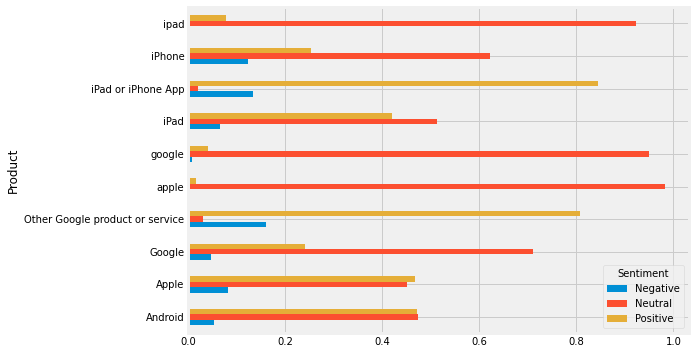

In [107]:
data.groupby('Product').Sentiment.value_counts(normalize=True).unstack(1).plot.barh(figsize=(8,6))

In [108]:
data=data.copy()

In [109]:
data['Product'].fillna('Unknown',inplace=True)

In [110]:
data

tweet_text  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.                     
1     @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW         
2     @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                                     
3     @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                                  
4     @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)                 
...                                                                                                                                   ...                 
9088  Ipad everywhere. #SXSW {link}                                                                                                                       
9089  Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link}  #google #circles                       
9090  Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev   
9091  Some Verizon iPhone customers complained their time fell back an hour this weekend.  Of course they were the New Yorkers who attended #SXSW.        
9092  ϡ_ʋ΋ҋ⋁__RT @mention Google Tests Check-in Offers At #SXSW {link}                                                                                    

                 Product Sentiment  
0     iPhone              Negative  
1     iPad or iPhone App  Positive  
2     iPad                Positive  
3     iPad or iPhone App  Negative  
4     Google              Positive  
...      ...                   ...  
9088  iPad                Positive  
9089  google              Neutral   
9090  Google              Neutral   
9091  iPhone              Neutral   
9092  Google              Neutral   

[8282 rows x 3 columns]

In [111]:
data[data['Product']=='Unknown'].sample()

tweet_text  \
3073  Brutal question served up to Marissa Mayer about JC Penney mapping getting rerouted to Macy's?  Uncomfortable for @mention #SXSW   

      Product Sentiment  
3073  Unknown  Neutral

In [112]:
data['Product'].value_counts()

iPad                               2054
Google                             1759
Apple                              1210
iPhone                             888 
Unknown                            806 
iPad or iPhone App                 470 
Android                            312 
Other Google product or service    292 
google                             259 
apple                              116 
ipad                               116 
Name: Product, dtype: int64

In [113]:
data = data[data['Product']!='Unknown'].copy()

### Duplicates

In [114]:
data[data.duplicated(subset='tweet_text',keep='first')]

tweet_text  \
468   Before It Even Begins, Apple Wins #SXSW {link}                                                                                                     
776   Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw                                                              
786   Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw                                                              
787   Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw @mention                                                     
2128  @mention at #sxsw: &quot;apple comes up with cool technology no one's ever heard of because they don't go to conferences&quot;                     
2232  Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw                                                 
2559  Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear                                                           
3813  Win free ipad 2 from webdoc.com #sxsw RT                                                                                                           
3814  Win free iPad 2 from webdoc.com #sxsw RT                                                                                                           
3950  Really enjoying the changes in Gowalla 3.0 for Android! Looking forward to seeing what else they &amp; Foursquare have up their sleeves at #SXSW   
3962  #SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan         
4897  Oh. My. God. The #SXSW app for iPad is pure, unadulterated awesome. It's easier to browse events on iPad than on the website!!!                    
5879  RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw                                                  
5881  RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw                                                  
5882  RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #SXSW                                                  
5883  RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw                                                  
5884  RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #SXSW                                                  
5885  RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw                                                  
5896  RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw                                                  
6294  RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw                                     
6295  RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #SXSW                                     
6296  RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw                                     
6297  RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #SXSW                                     
6298  RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw                                     
6299  RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #SXSW                                     
6300  RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw                    

### Check Point - Product Column Processed

In [115]:
data.to_csv('product_processed.csv',index=False)

In [134]:
data = pd.read_csv('product_processed.csv')

In [117]:
from Helpers import functions as fn

In [118]:
data.head(5)

tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.               
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2  @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                               
3  @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                            
4  @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)           

              Product Sentiment  
0  iPhone              Negative  
1  iPad or iPhone App  Positive  
2  iPad                Positive  
3  iPad or iPhone App  Negative  
4  Google              Positive

In [119]:
fn.Process_Tweet

<function Helpers.functions.Process_Tweet(text, remove_HTML=False, replace_moji_bake=False, remove_mentions=False, remove_hashtags=False, contraction_fix=False, strip_links=False, no_leading=False, lower=False, remove_numerals=False)>

In [120]:
import sys, importlib


In [121]:
importlib.reload(fn)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/seanyboy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


<module 'Helpers.functions' from '/Users/seanyboy/Documents/Flatiron/Phase_4/Twitter_Sentiment_Project/Helpers/functions.py'>

In [122]:
data.columns

Index(['tweet_text', 'Product', 'Sentiment'], dtype='object')

In [123]:
np.sum(data[data['Product']=='Unknown']['tweet_text'].str.contains('free'))

0

In [124]:
for w in product_words:
    print(w,np.sum(data[data['Product']=='Unknown']['tweet_text'].str.contains(w)))

iPad 0
Apple 0
iPad or iPhone App 0
Google 0
iPhone 0
Other Google product or service 0
Android App 0
Android 0
ipad 0
apple 0
ipad or iphone app 0
google 0
iphone 0
other google product or service 0
android app 0
android 0


In [125]:
data['Sentiment'].value_counts(normalize=True)

Neutral     0.539593
Positive    0.385500
Negative    0.074906
Name: Sentiment, dtype: float64

In [126]:
data[data['Product']!='Unknown']['Sentiment'].value_counts(normalize=True)

Neutral     0.539593
Positive    0.385500
Negative    0.074906
Name: Sentiment, dtype: float64

In [127]:
data['Product'].value_counts(normalize=True)

iPad                               0.274746
Google                             0.235286
Apple                              0.161851
iPhone                             0.118780
iPad or iPhone App                 0.062868
Android                            0.041734
Other Google product or service    0.039058
google                             0.034644
apple                              0.015516
ipad                               0.015516
Name: Product, dtype: float64

I will be dropping the tweets from the dataset that are "Unknown" in the product column after the preprocessing work that I have done. These tweets are neutral in sentiment AND they are not related to any relevant products, they will merely be muddy. In a real world scenario, we would filter out these irelevent tweets in pursuit of the cases we actually care about.

## Text Processing

Processing the text for modeling will the be great challenge of this task as there are multiple decision points that will affect the modeling process. Some of these I will consider hard preprocessing - aboslutely neccesary as part of data cleaning and some steps are optional and will be chosen as to how they affect scoring of the model. 

### Removing HTML characters

In [128]:
data.head(5)

tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.               
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2  @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                               
3  @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                            
4  @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)           

              Product Sentiment  
0  iPhone              Negative  
1  iPad or iPhone App  Positive  
2  iPad                Positive  
3  iPad or iPhone App  Negative  
4  Google              Positive

In [135]:
data['Remove_HTML']=fn.Process_Tweet(data['tweet_text'],remove_HTML=True,replace_moji_bake=True)

In [136]:
data.head(5)

tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.               
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2  @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                               
3  @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                            
4  @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)           

              Product Sentiment  \
0  iPhone              Negative   
1  iPad or iPhone App  Positive   
2  iPad                Positive   
3  iPad or iPhone App  Negative   
4  Google              Positive   

                                                                                                                                   Remove_HTML  
0  .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.              
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW  
2  @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                              
3  @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                           
4  @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)

Below is an example of this function in action. It removes the HTML that were poorly translated in the dataframe, especially text like '&amp' that appear throughout the dataset.

In [137]:
data.loc[6133,'tweet_text':'Remove_HTML']

tweet_text     The bad apple shows up late shoots down ideas and leaves early - meeting personality #2 #gamestorming #sxsw
Product        apple                                                                                                      
Sentiment      Neutral                                                                                                    
Remove_HTML    The bad apple shows up late shoots down ideas and leaves early - meeting personality #2 #gamestorming #sxsw
Name: 6133, dtype: object

In [138]:
np.sum(data['tweet_text'].str.contains('amp;'))

570

In [139]:
np.sum(data['Remove_HTML'].str.contains('amp;'))

0

In [140]:
np.sum(data['tweet_text'].str.contains('&quot;'))

690

In [141]:
np.sum(data['Remove_HTML'].str.contains('&quot;'))

0

In [142]:
np.sum(data['tweet_text'].str.contains('۝'))

0

In [143]:
np.sum(data['Remove_HTML'].str.contains('۝'))

0

Function successfully removed instances of HTML 'amp;' and '&quot;' from the dataset. That's progress for sure as these characters will not be helpful.

### Stripping Mentions From Tweets

In [144]:
data['no_mentions']=fn.Process_Tweet(data['Remove_HTML'],remove_mentions=True)

In [145]:
data['mentions']=data['Remove_HTML'].str.findall(r'[@]\w+')

In [146]:
data['mentions'] = data['mentions'].map(lambda x: ' '.join(x))

In [147]:
data['mentions'].value_counts()

                                                                                   3501
@mention                                                                           2684
@mention @mention                                                                  970 
@mention @mention @mention                                                         236 
@mention @mention @mention @mention                                                38  
@mention @mention @mention @mention @Schmittastic                                  3   
@madebymany                                                                        3   
@mention @mention @mention @mentionW                                               2   
@mention @mention @mention @mentionR                                               2   
@mention @mention @mention @mention @garyvee                                       2   
@mention @mention @mention @mention @jeremie                                       1   
@mention @mention @mention @ment

In [148]:
data[data['tweet_text'].str.contains('@mention')]

tweet_text  \
31    Attn: All  #SXSW frineds, @mention Register for #GDGTLive  and see Cobra iRadar for Android. {link}                                             
34    At #sxsw.  Oooh. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link}                                    
35    The best!  RT @mention Ha! First in line for #ipad2 at #sxsw &quot;pop-up&quot; Apple store was an event planner #eventprofs #pcma #engage365   
36    SPIN Play - a new concept in music discovery for your iPad from @mention &amp; spin.com {link} #iTunes #sxsw @mention                           
37    @mention  - False Alarm: Google Circles Not Coming Nowand Probably Not Ever? - {link} #Google #Circles #Social #SXSW                            
...                                                                                                                    ...                            
7462  Cue the hype RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link}  #google #circles                    
7469  Google says: want to give a lightning talk to a #H4ckers audience at #SXSW tonight? Email ben.mcgraw @mention gmail.com for a spot on stage.    
7470  @mention Yup, but I don't have a third app yet. I'm on Android, any suggestions? #SXSW CC: @mention                                             
7472  Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link}  #google #circles                   
7475  ϡ_ʋ΋ҋ⋁__RT @mention Google Tests Check-in Offers At #SXSW {link}                                                                                

      Product Sentiment  \
31    Android  Neutral    
34    Google   Neutral    
35    iPad     Positive   
36    iPad     Neutral    
37    Google   Negative   
...      ...        ...   
7462  google   Neutral    
7469  Google   Neutral    
7470  Android  Neutral    
7472  google   Neutral    
7475  Google   Neutral    

                                                                                                                                       Remove_HTML  \
31    Attn: All  #SXSW frineds, @mention Register for #GDGTLive  and see Cobra iRadar for Android. {link}                                            
34    At #sxsw.  Oooh. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link}                                   
35    The best!  RT @mention Ha! First in line for #ipad2 at #sxsw "pop-up" Apple store was an event planner #eventprofs #pcma #engage365            
36    SPIN Play - a new concept in music discovery for your iPad from @mention & spin.com {link} #iTunes #sxsw @mention                              
37    @mention  - False Alarm: Google Circles Not Coming Nowand Probably Not Ever? - {link} #Google #Circles #Social #SXSW                           
...                                                                                                                    ...                           
7462  Cue the hype RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link}  #google #circles                   
7469  Google says: want to give a lightning talk to a #H4ckers audience at #SXSW tonight? Email ben.mcgraw @mention gmail.com for a spot on stage.   
7470  @mention Yup, but I don't have a third app yet. I'm on Android, any suggestions? #SXSW CC: @mention                                            
7472  Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link}  #google #circles                  
7475  ϡ_ʋ΋ҋ⋁__RT @mention Google Tests Check-in Offers At #SXSW {link}                                                                               

                                                                                                                               no_mentions  \
31    Attn: All  #SXSW frineds,  Register for #GDGTLive 

In [149]:
data.head(5)

tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.               
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2  @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                               
3  @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                            
4  @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)           

              Product Sentiment  \
0  iPhone              Negative   
1  iPad or iPhone App  Positive   
2  iPad                Positive   
3  iPad or iPhone App  Negative   
4  Google              Positive   

                                                                                                                                   Remove_HTML  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.               
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2  @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                               
3  @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                            
4  @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)               

                                                                                                                  no_mentions  \
0  . I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.       
1   Know about  ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2   Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                         
3   I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                
4   great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)        

             mentions  
0  @wesley83           
1  @jessedee @fludapp  
2  @swonderlin         
3  @sxsw               
4  @sxtxstate

These mentions will not semantically improve the model, so I will safely proceed to removing them from the dataset.

### Removing and Preserving Hashtags

Preserving the hashtags may be helpful to additional EDA.

In [150]:
data['hashtags'] = data['no_mentions'].str.findall(r'\B#\w*[a-zA-Z]+\w*')

In [151]:
data['hashtags'] = data['hashtags'].map(lambda x: ' '.join(x))

In [152]:
data['hashtags'].value_counts()

#sxsw                       2140
#SXSW                       1970
#SxSW                       71  
#Apple #SXSW                47  
#sxsw #sxswi                36  
                            ..  
#Apple #Grrr #sxsw          1   
#apps #sxsw #hipstamatic    1   
#iPad #Apple #SXSW          1   
#Sxsw #fail                 1   
#SXSW #rejection            1   
Name: hashtags, Length: 1672, dtype: int64

In [155]:
data['no_hashtags'] = fn.Process_Tweet(data['no_mentions'],remove_hashtags=True)

In [156]:
data.head(5)

tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.               
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2  @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                               
3  @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                            
4  @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)           

              Product Sentiment  \
0  iPhone              Negative   
1  iPad or iPhone App  Positive   
2  iPad                Positive   
3  iPad or iPhone App  Negative   
4  Google              Positive   

                                                                                                                                   Remove_HTML  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.               
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2  @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                               
3  @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                            
4  @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)               

                                                                                                                  no_mentions  \
0  . I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.       
1   Know about  ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2   Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                         
3   I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                
4   great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)        

             mentions            hashtags  \
0  @wesley83           #RISE_Austin #SXSW   
1  @jessedee @fludapp  #SXSW                
2  @swonderlin         #iPad #SXSW          
3  @sxsw               #sxsw                
4  @sxtxstate          #SXSW                

                                                                                                             no_hashtags  
0  . I have a 3G iPhone. After 3 hrs tweeting at , it was dead!  I need to upgrade. Plugin stations at .                  
1   Know about  ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at   
2   Can not wait for  2 also. They should sale them down at .                                                             
3   I hope this year's festival isn't as crashy as this year's iPhone app.                                                
4   great stuff on Fri : Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)

### Replacing Contractions

Contraction replacement is a helpful way to reduce computational cost and streamline the dataset.

In [157]:
data['no_contractions'] = fn.Process_Tweet(data['no_hashtags'],contraction_fix=True)

In [158]:
data.head()

tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.               
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2  @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                               
3  @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                            
4  @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)           

              Product Sentiment  \
0  iPhone              Negative   
1  iPad or iPhone App  Positive   
2  iPad                Positive   
3  iPad or iPhone App  Negative   
4  Google              Positive   

                                                                                                                                   Remove_HTML  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.               
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2  @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                               
3  @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                            
4  @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)               

                                                                                                                  no_mentions  \
0  . I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.       
1   Know about  ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2   Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                         
3   I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                
4   great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)        

             mentions            hashtags  \
0  @wesley83           #RISE_Austin #SXSW   
1  @jessedee @fludapp  #SXSW                
2  @swonderlin         #iPad #SXSW          
3  @sxsw               #sxsw                
4  @sxtxstate          #SXSW                

                                                                                                             no_hashtags  \
0  . I have a 3G iPhone. After 3 hrs tweeting at , it was dead!  I need to upgrade. Plugin stations at .                   
1   Know about  ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at    
2   Can not wait for  2 also. They should sale them down at .                                                              
3   I hope this year's festival isn't as crashy as this year's iPhone app.                                                 
4   great stuff on Fri : Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)        

                                                                                                            no_contractions  
0  . I have a 3G iPhone. After 3 hrs tweeting at , it was dead!  I need to upgrade. Plugin stations at .                     
1   Know about  ? Awesome iPad/iPhone app that you will likely appreciate for its design. Also, they are giving free Ts at  

### Removing Texts from Links

Links appear as a result of the webscraping performed and should replaced.

In [159]:
np.sum(data['no_contractions'].str.contains('link'))

3169

In [160]:
np.sum(data['no_contractions'].str.contains('http'))

23

In [161]:
data['no_links']=fn.Process_Tweet(data['no_contractions'],strip_links=True)

In [162]:
np.sum(data['no_links'].str.contains('link'))

26

In [163]:
np.sum(data['no_links'].str.contains('http'))

0

In [164]:
data[data['no_links'].str.contains('link')]

tweet_text  \
581   Disliking iPhone twitter auto shortening links for me. #sxsw                                                                                         
683   Google to launch new social network Circles, linking u more closely to peeps u connect w/most. possibly today @mention #sxsw!                        
887   #sxsw app schedule #fail try sched.org - google: sched sxsw 2011 click first link. All the unofficial parties and room counts. Genius.               
1247  At Google's scale, tiny changes (even in colors of blue) can be meaningful. There's an optimum shade of blue for links. #sxsw @mention               
1258  @mention (CEO Gowalla) tells his journey of Blinksale to iconbuffet to Packrat. Then the #iPhone was born and the lightbulb turned on...#sxsw        
1344  @mention @mention Thank you all for retweeting @mention @mention &amp; me about the link re #sxsw &amp; the popup Apple Store.                       
1415  Enjoying #SXSW Radio Station {link} If you have an iphone use link {link} &amp; plug it into your sound system.                                      
1617  Google analytics can track offsite links as virtual page views using JavaScript. #moreknowledge #sxsw #mitharvard                                    
1667  Google plans to bring &quot;The Power of Here&quot; to life in the future by linking the digital and the physical worlds. {link} #sxsw               
1799  We're creatures of habit. Google found that CTRs for blue links far outpaced green. The darker the link, the more clicks it got. #sxsw               
3001  See? So big my links smooshed. Here's Google Realtime for #SXSW {link}                                                                               
3366  Any #Google fans in town for #SXSW? Stop by the Austin GTUG meeting Wednesday the 7th at 7:00pm. map link: {link}                                    
3439  @mention link to google story doesn't work. ??  thx! #SXSW                                                                                           
3440  @mention link? or I have to google it huh?  see u in austin for #SXSW? let me buy you a drink if you'll be there!                                    
3818  Interesting RT @mention Google analytics can track offsite links as virtual pg views using Script. #moreknowledge #sxsw #mitharvard                  
4371  RT @mention #sxsw app schedule #fail try sched.org - google: sched sxsw 2011 click first link. All the unofficial parties and room counts. Genius.   
4443  RT @mention Any #Google fans in town for #SXSW? Stop by the Austin GTUG meeting Wednesday the 7th at 7:00pm. map link: {link}                        
4763  RT @mention Google analytics can track offsite links as virtual page views using JavaScript. #moreknowledge #sxsw #mitharvard                        
4820  RT @mention Google tested 41 shades of blue for link colors AND it made a difference. At scale the nuances really matter. #SXSW                      
4871  RT @mention Google to launch new social network Circles, linking u more closely to peeps u connect w/most. possibly today @mention #sxsw!            
5484  RT @mention See? So big my links smooshed. Here's Google Realtime for #SXSW {link}                                                                   
5591  RT @mention This @mention article about #SXSW is so good I'm linking to it on an iPhone on a train: {link}                                           
6152  #sxsw #sxprotect  {link} is the Google Doc to get all the relevant links from this panel                                                             
6470  Many folks have asked about my iPhone battery case. Here's the link {link} #sxsw #fb #Li                                                             
6665  Google tested 41 shades of blue for link colors AND it made a difference. At scale the nuances really matter. #SXSW                                  
7256  Free #SXSW streams/downloads via new free Winamp app in Android market, direct l

In [165]:
data[data['no_links'].str.contains('http')]

Empty DataFrame
Columns: [tweet_text, Product, Sentiment, Remove_HTML, no_mentions, mentions, hashtags, no_hashtags, no_contractions, no_links]
Index: []

### Leading Punctuation

In [166]:
data.head(5)

tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.               
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2  @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                               
3  @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                            
4  @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)           

              Product Sentiment  \
0  iPhone              Negative   
1  iPad or iPhone App  Positive   
2  iPad                Positive   
3  iPad or iPhone App  Negative   
4  Google              Positive   

                                                                                                                                   Remove_HTML  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.               
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2  @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                               
3  @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                            
4  @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)               

                                                                                                                  no_mentions  \
0  . I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.       
1   Know about  ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2   Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                         
3   I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                
4   great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)        

             mentions            hashtags  \
0  @wesley83           #RISE_Austin #SXSW   
1  @jessedee @fludapp  #SXSW                
2  @swonderlin         #iPad #SXSW          
3  @sxsw               #sxsw                
4  @sxtxstate          #SXSW                

                                                                                                             no_hashtags  \
0  . I have a 3G iPhone. After 3 hrs tweeting at , it was dead!  I need to upgrade. Plugin stations at .                   
1   Know about  ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at    
2   Can not wait for  2 also. They should sale them down at .                                                              
3   I hope this year's festival isn't as crashy as this year's iPhone app.                                                 
4   great stuff on Fri : Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)        

                                                                                                            no_contractions  \
0  . I have a 3G iPhone. After 3 hrs tweeting at , it was dead!  I need to upgrade. Plugin stations at .                      
1   Know about  ? Awesome iPad/iPhone app that you will likely appreciate for its design. Also, they are giving free Ts at

In [167]:
#Some tweets have leading punctuation that must be removed
data['no_leading']=fn.Process_Tweet(data['no_links'],no_leading=True)

In [168]:
data.head(5)

tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.               
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2  @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                               
3  @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                            
4  @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)           

              Product Sentiment  \
0  iPhone              Negative   
1  iPad or iPhone App  Positive   
2  iPad                Positive   
3  iPad or iPhone App  Negative   
4  Google              Positive   

                                                                                                                                   Remove_HTML  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.               
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2  @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                               
3  @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                            
4  @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)               

                                                                                                                  no_mentions  \
0  . I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.       
1   Know about  ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2   Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                         
3   I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                
4   great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)        

             mentions            hashtags  \
0  @wesley83           #RISE_Austin #SXSW   
1  @jessedee @fludapp  #SXSW                
2  @swonderlin         #iPad #SXSW          
3  @sxsw               #sxsw                
4  @sxtxstate          #SXSW                

                                                                                                             no_hashtags  \
0  . I have a 3G iPhone. After 3 hrs tweeting at , it was dead!  I need to upgrade. Plugin stations at .                   
1   Know about  ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at    
2   Can not wait for  2 also. They should sale them down at .                                                              
3   I hope this year's festival isn't as crashy as this year's iPhone app.                                                 
4   great stuff on Fri : Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)        

                                                                                                            no_contractions  \
0  . I have a 3G iPhone. After 3 hrs tweeting at , it was dead!  I need to upgrade. Plugin stations at .                      
1   Know about  ? Awesome iPad/iPhone app that you will likely appreciate for its design. Also, they are giving free Ts at

In [169]:
data.sample(5)

tweet_text  \
5713  RT @mention Will we see Google's new Social Network &quot;Circles&quot; today? {link} #SxSW #SxSWi                          
687   Google to launch social network Google Circles  at some point - but not at SXSW today.  :-(   {link}   #sxsw                
4355  RT @mention #SXSW #beyondwc Analytics 101: Google Analytics is a standard to use.                                           
1183  Confirmed! Apple store 2 week popup in Austin for #SXSW Now with picture!  {link} ( via @mention who gave us no credit! )   
1514  It's not a rumor: Apple opening up a temporary store in downtown Austin for #SXSW &amp;iPad 2 launch {link}                 

     Product Sentiment  \
5713  Google  Neutral    
687   Google  Neutral    
4355  Google  Positive   
1183  Apple   Neutral    
1514  iPad    Neutral    

                                                                                                                    Remove_HTML  \
5713  RT @mention Will we see Google's new Social Network "Circles" today? {link} #SxSW #SxSWi                                    
687   Google to launch social network Google Circles  at some point - but not at SXSW today.  :-(   {link}   #sxsw                
4355  RT @mention #SXSW #beyondwc Analytics 101: Google Analytics is a standard to use.                                           
1183  Confirmed! Apple store 2 week popup in Austin for #SXSW Now with picture!  {link} ( via @mention who gave us no credit! )   
1514  It's not a rumor: Apple opening up a temporary store in downtown Austin for #SXSW &iPad 2 launch {link}                     

                                                                                                            no_mentions  \
5713  RT  Will we see Google's new Social Network "Circles" today? {link} #SxSW #SxSWi                                    
687   Google to launch social network Google Circles  at some point - but not at SXSW today.  :-(   {link}   #sxsw        
4355  RT  #SXSW #beyondwc Analytics 101: Google Analytics is a standard to use.                                           
1183  Confirmed! Apple store 2 week popup in Austin for #SXSW Now with picture!  {link} ( via  who gave us no credit! )   
1514  It's not a rumor: Apple opening up a temporary store in downtown Austin for #SXSW &iPad 2 launch {link}             

      mentions         hashtags  \
5713  @mention  #SxSW #SxSWi      
687             #sxsw             
4355  @mention  #SXSW #beyondwc   
1183  @mention  #SXSW             
1514            #SXSW             

                                                                                                       no_hashtags  \
5713  RT  Will we see Google's new Social Network "Circles" today? {link}                                            
687   Google to launch social network Google Circles  at some point - but not at SXSW today.  :-(   {link}           
4355  RT    Analytics 101: Google Analytics is a standard to use.                                                    
1183  Confirmed! Apple store 2 week popup in Austin for  Now with picture!  {link} ( via  who gave us no credit! )   
1514  It's not a rumor: Apple opening up a temporary store in downtown Austin for  &iPad 2 launch {link}             

                                                                                                   no_contractions  \
5713  RT  Will we see Google's new Social Network "Circles" today? {link}                                            
687   Google to launch social network Google Circles  at some point - but not at SXSW today.  :-(   {link}           
4355  RT    Analytics 101: Google Analytics is a standard to use.                                                    
1183  Confirmed! Apple store 2 week popup in Austin for  Now with picture!  {link} ( via  who gave us no credit! )   
1514  It is not a rumor: Apple opening up a temporary store in downtown Austin for  &iPad 2 launch {link}            

                  

### Converting Numerals to Words

In [170]:
data['no_numerals'] = fn.Process_Tweet(data['no_leading'],remove_numerals=True)

In [171]:
data.head(5)

tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.               
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2  @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                               
3  @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                            
4  @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)           

              Product Sentiment  \
0  iPhone              Negative   
1  iPad or iPhone App  Positive   
2  iPad                Positive   
3  iPad or iPhone App  Negative   
4  Google              Positive   

                                                                                                                                   Remove_HTML  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.               
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2  @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                               
3  @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                            
4  @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)               

                                                                                                                  no_mentions  \
0  . I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.       
1   Know about  ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2   Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                         
3   I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                
4   great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)        

             mentions            hashtags  \
0  @wesley83           #RISE_Austin #SXSW   
1  @jessedee @fludapp  #SXSW                
2  @swonderlin         #iPad #SXSW          
3  @sxsw               #sxsw                
4  @sxtxstate          #SXSW                

                                                                                                             no_hashtags  \
0  . I have a 3G iPhone. After 3 hrs tweeting at , it was dead!  I need to upgrade. Plugin stations at .                   
1   Know about  ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at    
2   Can not wait for  2 also. They should sale them down at .                                                              
3   I hope this year's festival isn't as crashy as this year's iPhone app.                                                 
4   great stuff on Fri : Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)        

                                                                                                            no_contractions  \
0  . I have a 3G iPhone. After 3 hrs tweeting at , it was dead!  I need to upgrade. Plugin stations at .                      
1   Know about  ? Awesome iPad/iPhone app that you will likely appreciate for its design. Also, they are giving free Ts at

In [172]:
data.sample(5)

tweet_text  \
585   Microsoft is going to launch IE9 at #SXSW. Amid all those glowing Apple logos. #classicaudiencemisread                        
6702  #sxsw Is SXSW getting its own Apple store?: The geeks cried.\nYes the iPad 2 is coming, but it۪s coming this Frid... {link}   
5359  RT @mention RT @mention Apple is &quot;the classiest, fascist company in America,&quot; says @mention #sxsw                   
5609  RT @mention Tips from Google's @mention fewer people on teams, and think by making. Prototyping is key. #agileagency #sxsw    
151   I'm up to 2 iPad 2s seen in the wild. Both people say it is fast, but the still pics are terrible. #sxsw                      

     Product Sentiment  \
585   Apple   Neutral    
6702  iPad    Neutral    
5359  Apple   Negative   
5609  Google  Neutral    
151   iPad    Negative   

                                                                                                                      Remove_HTML  \
585   Microsoft is going to launch IE9 at #SXSW. Amid all those glowing Apple logos. #classicaudiencemisread                        
6702  #sxsw Is SXSW getting its own Apple store?: The geeks cried.\nYes the iPad 2 is coming, but it۪s coming this Frid... {link}   
5359  RT @mention RT @mention Apple is "the classiest, fascist company in America," says @mention #sxsw                             
5609  RT @mention Tips from Google's @mention fewer people on teams, and think by making. Prototyping is key. #agileagency #sxsw    
151   I'm up to 2 iPad 2s seen in the wild. Both people say it is fast, but the still pics are terrible. #sxsw                      

                                                                                                                      no_mentions  \
585   Microsoft is going to launch IE9 at #SXSW. Amid all those glowing Apple logos. #classicaudiencemisread                        
6702  #sxsw Is SXSW getting its own Apple store?: The geeks cried.\nYes the iPad 2 is coming, but it۪s coming this Frid... {link}   
5359  RT  RT  Apple is "the classiest, fascist company in America," says  #sxsw                                                     
5609  RT  Tips from Google's  fewer people on teams, and think by making. Prototyping is key. #agileagency #sxsw                    
151   I'm up to 2 iPad 2s seen in the wild. Both people say it is fast, but the still pics are terrible. #sxsw                      

                        mentions                       hashtags  \
585                               #SXSW #classicaudiencemisread   
6702                              #sxsw                           
5359  @mention @mention @mention  #sxsw                           
5609  @mention @mention           #agileagency #sxsw              
151                               #sxsw                           

                                                                                                                 no_hashtags  \
585   Microsoft is going to launch IE9 at . Amid all those glowing Apple logos.                                                
6702   Is SXSW getting its own Apple store?: The geeks cried.\nYes the iPad 2 is coming, but it۪s coming this Frid... {link}   
5359  RT  RT  Apple is "the classiest, fascist company in America," says                                                       
5609  RT  Tips from Google's  fewer people on teams, and think by making. Prototyping is key.                                  
151   I'm up to 2 iPad 2s seen in the wild. Both people say it is fast, but the still pics are terrible.                       

                                                                                                             no_contractions  \
585   Microsoft is going to launch IE9 at . Amid all those glowing Apple logos.                                                
6702   Is SXSW getting its own Apple store?: The geeks cried.\nYes the iPad 2 is coming, but it۪s coming this Frid... {link}   
5359  RT 

### Lowercasing

In [173]:
data['lower_case'] = fn.Process_Tweet(data['no_numerals'],lower=True)

In [174]:
data.head(5)

tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.               
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2  @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                               
3  @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                            
4  @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)           

              Product Sentiment  \
0  iPhone              Negative   
1  iPad or iPhone App  Positive   
2  iPad                Positive   
3  iPad or iPhone App  Negative   
4  Google              Positive   

                                                                                                                                   Remove_HTML  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.               
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2  @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                               
3  @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                            
4  @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)               

                                                                                                                  no_mentions  \
0  . I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.       
1   Know about  ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2   Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                         
3   I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                
4   great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)        

             mentions            hashtags  \
0  @wesley83           #RISE_Austin #SXSW   
1  @jessedee @fludapp  #SXSW                
2  @swonderlin         #iPad #SXSW          
3  @sxsw               #sxsw                
4  @sxtxstate          #SXSW                

                                                                                                             no_hashtags  \
0  . I have a 3G iPhone. After 3 hrs tweeting at , it was dead!  I need to upgrade. Plugin stations at .                   
1   Know about  ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at    
2   Can not wait for  2 also. They should sale them down at .                                                              
3   I hope this year's festival isn't as crashy as this year's iPhone app.                                                 
4   great stuff on Fri : Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)        

                                                                                                            no_contractions  \
0  . I have a 3G iPhone. After 3 hrs tweeting at , it was dead!  I need to upgrade. Plugin stations at .                      
1   Know about  ? Awesome iPad/iPhone app that you will likely appreciate for its design. Also, they are giving free Ts at

The Processing has removed a lot of the characters that need to be removed for modeling, but some characters remain. Abbreviations are another sticky point, certain lingo and shortening of words was specific to this era of twitter where tweets were hard-capped at 140 characters. 

### Replacing Other Special Characers

Most if not all of the punctuation have been removed, some punctuation can be valuable for more advanced models. There are numerals that need to be converted into the words for numerals. There are many abbrevations and slang terms in the the text as well. At this point I will stop and just take a look at the top words in the processed text.

## Word Clouds

### Basic Word Cloud Cleaned Text

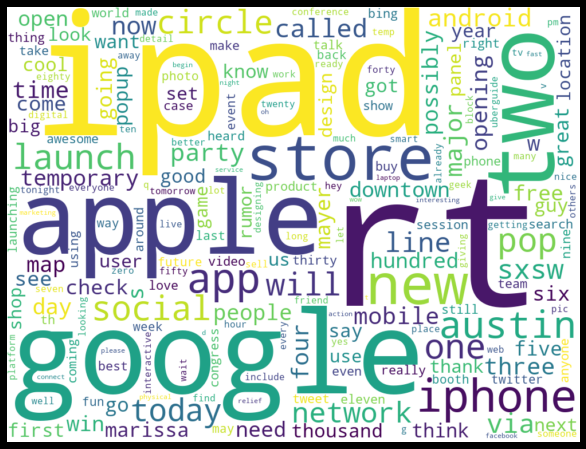

In [175]:
sample_text = ''.join(data['lower_case'])
wordcloud = WordCloud(width=1000, height=760, background_color="white",collocations=False).generate(sample_text)

# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Negative Word Cloud

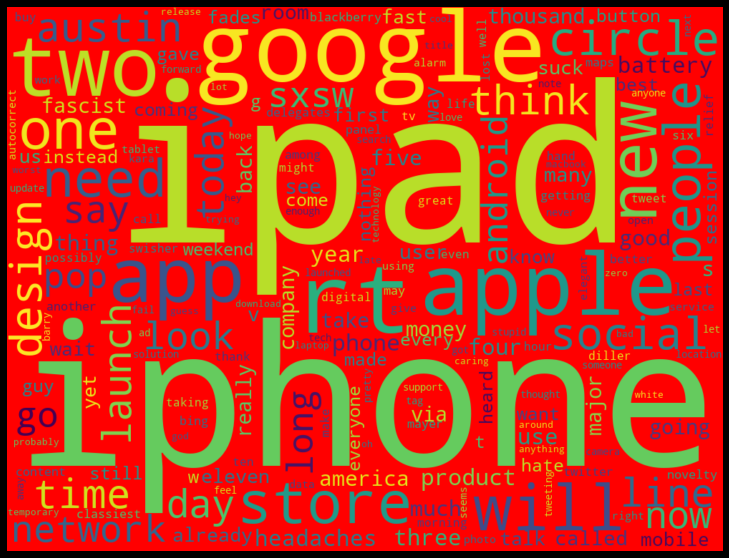

In [177]:
sample_text = ''.join(data[data['Sentiment']=='Negative']['lower_case'])
wordcloud = WordCloud(width=1000, height=760, background_color="red",collocations=False).generate(sample_text)

# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Positive Word Cloud

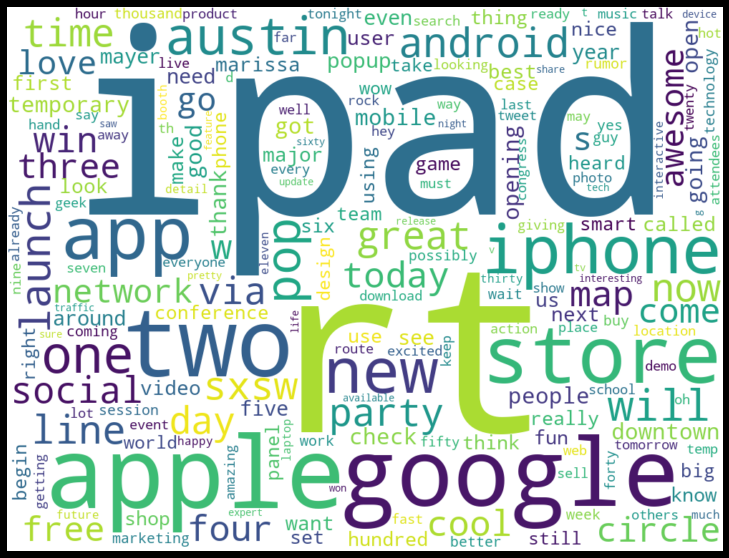

In [178]:
sample_text = ''.join(data[data['Sentiment']=='Positive']['lower_case'])
wordcloud = WordCloud(width=1000, height=760, background_color="white",collocations=False).generate(sample_text)

# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

A quick glance so some interesting words in the given sentiments. It looks like "fascist" and "headaches" pop up in the negative tweets.

### Fun with Negative Words

In [180]:
np.sum(data[data['Sentiment']=='Negative']['lower_case'].str.contains('fascist'))

14

In [181]:
np.sum(data[data['Sentiment']=='Negative']['lower_case'].str.contains('headache'))

17

In [182]:
np.sum(data[data['Sentiment']=='Positive']['lower_case'].str.contains('party'))/np.sum(data['Sentiment']=='Positive')

0.04198473282442748

In [183]:
np.sum(data[data['Sentiment']=='Negative']['lower_case'].str.contains('party'))

6

In [184]:
np.sum(data[data['Sentiment']=='Neutral']['lower_case'].str.contains('party'))/np.sum(data['Sentiment']=='Neutral')

0.03668815071888944

### Word Percentages

In [185]:
def word_percentages(data,word):
    neg_occurances = np.sum(data[data['Sentiment']=='Negative']['lower_case'].str.contains(word))/np.sum(data['Sentiment']=='Negative')
    poz_occurances = np.sum(data[data['Sentiment']=='Positive']['lower_case'].str.contains(word))/np.sum(data['Sentiment']=='Positive')
    neutral_occurances = np.sum(data[data['Sentiment']=='Neutral']['lower_case'].str.contains(word))/np.sum(data['Sentiment']=='Neutral')
    return f'The word {word} appears {round(neg_occurances,4)}% of the negative portion of the dataset, {round(poz_occurances,4)} of the positive portion of the dataset, and {round(neutral_occurances,4)} of the neutral portion of the dataset.'

In [186]:
word_percentages(data,'fascist')

'The word fascist appears 0.025% of the negative portion of the dataset, 0.0 of the positive portion of the dataset, and 0.0002 of the neutral portion of the dataset.'

In [187]:
word_percentages(data,'party')

'The word party appears 0.0107% of the negative portion of the dataset, 0.042 of the positive portion of the dataset, and 0.0367 of the neutral portion of the dataset.'

In [188]:
word_percentages(data,'free')

'The word free appears 0.0036% of the negative portion of the dataset, 0.0316 of the positive portion of the dataset, and 0.0243 of the neutral portion of the dataset.'

In [189]:
word_percentages(data,'headache')

'The word headache appears 0.0304% of the negative portion of the dataset, 0.001 of the positive portion of the dataset, and 0.0032 of the neutral portion of the dataset.'

In [190]:
word_percentages(data,'app')

'The word app appears 0.3304% of the negative portion of the dataset, 0.4046 of the positive portion of the dataset, and 0.3024 of the neutral portion of the dataset.'

In [191]:
word_percentages(data,'cool')

'The word cool appears 0.0089% of the negative portion of the dataset, 0.0441 of the positive portion of the dataset, and 0.0047 of the neutral portion of the dataset.'

## Lematization

In [194]:
#Grabbing Stopwords from NLTK
sw = stopwords.words('english')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/seanyboy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [195]:
#Borrowed Function to attatch parts of speech for lemmonization
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [199]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from a corpus
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return (doc)

In [200]:
data['lemma_tokens']= [doc_preparer(doc, sw) for doc in data['lower_case']]

### Top Lemmatized Words from Dataset

In [201]:
corpus = [' '.join(data.lemma_tokens.apply(lambda x: ', '.join([str(i) for i in x])))]
neg_corpus = [' '.join(data[data['Sentiment']=='Negative']['lemma_tokens'].apply(lambda x: ', '.join([str(i) for i in x])))]
poz_corpus = [' '.join(data[data['Sentiment']=='Positive']['lemma_tokens'].apply(lambda x: ', '.join([str(i) for i in x])))]
neutral_corpus = [' '.join(data[data['Sentiment']=='Neutral']['lemma_tokens'].apply(lambda x: ', '.join([str(i) for i in x])))]

In [202]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [203]:
get_top_n_words(neg_corpus,n=10)

[('ipad', 183),
 ('iphone', 149),
 ('google', 139),
 ('rt', 137),
 ('apple', 106),
 ('two', 100),
 ('app', 57),
 ('store', 47),
 ('new', 45),
 ('one', 43)]

In [204]:
get_top_n_words(poz_corpus,n=10)

[('ipad', 1000),
 ('rt', 912),
 ('apple', 740),
 ('two', 672),
 ('google', 661),
 ('store', 547),
 ('iphone', 441),
 ('app', 378),
 ('new', 355),
 ('get', 285)]

In [205]:
get_top_n_words(corpus=neutral_corpus,n=10)

[('rt', 1416),
 ('google', 1391),
 ('ipad', 1018),
 ('apple', 873),
 ('store', 776),
 ('two', 706),
 ('new', 586),
 ('launch', 503),
 ('iphone', 465),
 ('austin', 458)]

It's more or less the same words as the top words in each of the dataets.

In [206]:
def get_top_tfidf_words(corpus, n=None):
    vec = TfidfVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [207]:
get_top_tfidf_words(poz_corpus,n=20)

[('ipad', 0.43973617798157927),
 ('rt', 0.40103939431920027),
 ('apple', 0.32540477170636867),
 ('two', 0.2955027116036213),
 ('google', 0.2906656136458239),
 ('store', 0.24053568935592387),
 ('iphone', 0.19392365448987645),
 ('app', 0.16622027527703698),
 ('new', 0.15610634318346064),
 ('get', 0.1253248107247501),
 ('austin', 0.1103737806733764),
 ('one', 0.10949430831741323),
 ('pop', 0.09454327826603955),
 ('launch', 0.0848690823504448),
 ('go', 0.08442934617246323),
 ('open', 0.07519488643485006),
 ('android', 0.06727963523118163),
 ('party', 0.06727963523118163),
 ('line', 0.06288227345136584),
 ('come', 0.06244253727338426)]

In [208]:
get_top_tfidf_words(neg_corpus,n=20)

[('ipad', 0.4503620327693096),
 ('iphone', 0.3666882124733723),
 ('google', 0.34207826532750835),
 ('rt', 0.3371562758983356),
 ('apple', 0.26086543974615745),
 ('two', 0.2460994714586391),
 ('app', 0.1402766987314243),
 ('store', 0.11566675158556038),
 ('new', 0.1107447621563876),
 ('one', 0.10582277272721481),
 ('like', 0.10336177801262843),
 ('get', 0.10090078329804203),
 ('need', 0.08613481501052368),
 ('people', 0.08613481501052368),
 ('go', 0.0812128255813509),
 ('circle', 0.07136884672300534),
 ('launch', 0.07136884672300534),
 ('design', 0.06890785200841895),
 ('think', 0.06890785200841895),
 ('social', 0.06890785200841895)]

In [209]:
get_top_tfidf_words(neutral_corpus,20)

[('rt', 0.4431161174049729),
 ('google', 0.43529273962593035),
 ('ipad', 0.3185679431626147),
 ('apple', 0.27319235204416764),
 ('store', 0.24283764626148235),
 ('two', 0.22093218848016305),
 ('new', 0.18337997514075857),
 ('launch', 0.15740636091433713),
 ('iphone', 0.1455148266901924),
 ('austin', 0.14332428091206045),
 ('social', 0.13550090313301785),
 ('circle', 0.12799046046513696),
 ('today', 0.11641186135215391),
 ('pop', 0.10420739201684745),
 ('network', 0.10358152179452404),
 ('one', 0.09388053334851122),
 ('open', 0.08981237690340907),
 ('call', 0.08793476623643884),
 ('get', 0.08762183112527713),
 ('app', 0.08105019379088135)]

### Added Stopwords

For the sake of experimentation I will remove the top words and put them in the stopwords list.

In [223]:
top_words = get_top_tfidf_words(corpus,10)

In [224]:
top_words = [w[0] for w in top_words]

In [225]:
sw.extend(top_words)

In [226]:
data['new_stop_words']= [doc_preparer(doc, sw) for doc in data['lower_case']]

In [227]:
corpus = [' '.join(data.lemma_tokens.apply(lambda x: ', '.join([str(i) for i in x])))]
neg_corpus = [' '.join(data[data['Sentiment']=='Negative']['new_stop_words'].apply(lambda x: ', '.join([str(i) for i in x])))]
poz_corpus = [' '.join(data[data['Sentiment']=='Positive']['new_stop_words'].apply(lambda x: ', '.join([str(i) for i in x])))]
neutral_corpus = [' '.join(data[data['Sentiment']=='Neutral']['new_stop_words'].apply(lambda x: ', '.join([str(i) for i in x])))]

In [228]:
get_top_tfidf_words(corpus,10)

[('rt', 0.42825796789345494),
 ('ipad', 0.3823918001352918),
 ('google', 0.3806544452959674),
 ('apple', 0.2986512968798576),
 ('two', 0.2567810452521405),
 ('store', 0.23801761298743743),
 ('iphone', 0.18329093554872006),
 ('new', 0.17130318715738196),
 ('austin', 0.12752184520640808),
 ('launch', 0.12595822585101615)]

In [229]:
get_top_tfidf_words(neg_corpus,10)

[('app', 0.270537449515196),
 ('one', 0.20408965489742853),
 ('like', 0.1993433838533023),
 ('get', 0.19459711280917605),
 ('need', 0.16611948654441858),
 ('people', 0.16611948654441858),
 ('go', 0.1566269444561661),
 ('circle', 0.1376418602796611),
 ('design', 0.13289558923553485),
 ('think', 0.13289558923553485)]

In [230]:
get_top_tfidf_words(poz_corpus,10)

[('app', 0.3478423690859145),
 ('get', 0.26134188576825323),
 ('one', 0.2291342590010389),
 ('pop', 0.1969266322338246),
 ('go', 0.1766818382658613),
 ('open', 0.15459660848262866),
 ('android', 0.14079333986810824),
 ('party', 0.14079333986810824),
 ('line', 0.1315911607917613),
 ('sxsw', 0.13067094288412662)]

In [231]:
get_top_tfidf_words(neutral_corpus,10)

[('social', 0.28230889178647417),
 ('circle', 0.26666128577521464),
 ('today', 0.24253789317452285),
 ('pop', 0.21711053340622607),
 ('network', 0.21580656623862113),
 ('one', 0.19559507514074423),
 ('call', 0.1832073870484971),
 ('get', 0.18125143629708965),
 ('open', 0.17994746912948467),
 ('app', 0.1688637482048425)]

### TFIDF WordClouds

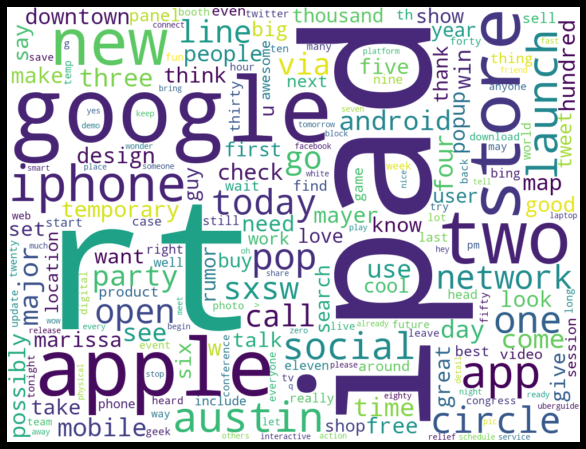

In [232]:
sample_text = ' '.join(data.lemma_tokens.apply(lambda x: ', '.join([str(i) for i in x])))
wordcloud = WordCloud(width=1000, height=760, background_color="white",collocations=False).generate(sample_text)

# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

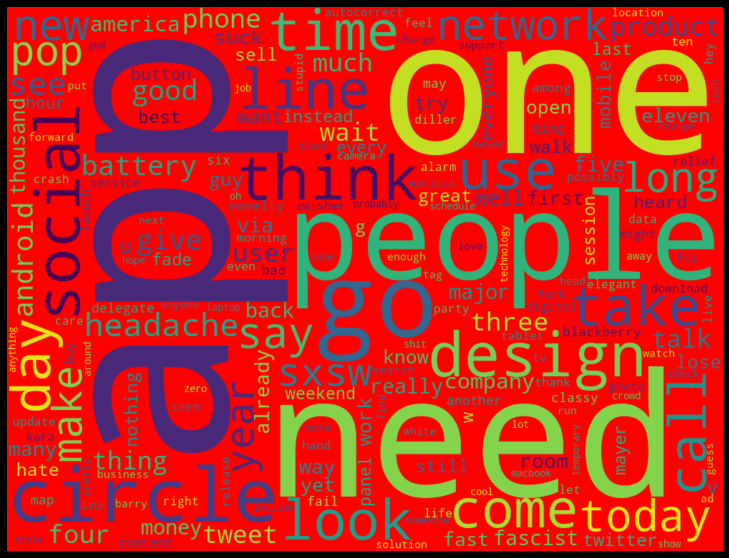

In [233]:
sample_text = ' '.join(data[data['Sentiment']=='Negative']['new_stop_words'].apply(lambda x: ', '.join([str(i) for i in x])))
wordcloud = WordCloud(width=1000, height=760, background_color="red",collocations=False).generate(sample_text)

# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

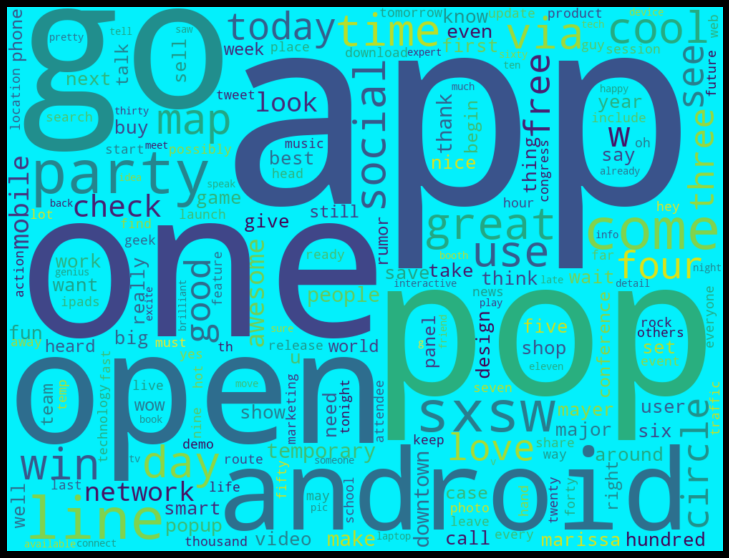

In [404]:
sample_text = ' '.join(data[data['Sentiment']=='Positive']['new_stop_words'].apply(lambda x: ', '.join([str(i) for i in x])))
wordcloud = WordCloud(width=1000, height=760, background_color="#03f0fc",collocations=False).generate(sample_text)

# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(20,10),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Bigram Wordclouds

In [267]:
def get_top_tfidf_words(corpus, n=None):
    vec = TfidfVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [236]:
get_top_tfidf_words(poz_corpus,10)

[('social network', 0.27653733830498894),
 ('marissa mayer', 0.1929330267244109),
 ('network call', 0.18328637538819037),
 ('call circle', 0.18328637538819037),
 ('major social', 0.1736397240519698),
 ('open pop', 0.16720862316115612),
 ('open temporary', 0.15434642137952873),
 ('even begin', 0.13183756826168078),
 ('possibly today', 0.13183756826168078),
 ('circle possibly', 0.12862201781627394)]

In [271]:
neg_bigrams

[('design headache', 0.18575075473448743),
 ('social network', 0.1638977247657242),
 ('company america', 0.14204469479696097),
 ('major social', 0.13111817981257937),
 ('fascist company', 0.13111817981257937),
 ('network call', 0.12019166482819775),
 ('call circle', 0.10926514984381613),
 ('news apps', 0.09833863485943452),
 ('thousand eleven', 0.09833863485943452),
 ('novelty news', 0.09833863485943452),
 ('fade fast', 0.09833863485943452),
 ('fast among', 0.09833863485943452),
 ('best thing', 0.08741211987505292),
 ('thing heard', 0.08741211987505292),
 ('give money', 0.08741211987505292),
 ('money relief', 0.08741211987505292),
 ('relief need', 0.08741211987505292),
 ('classy fascist', 0.08741211987505292),
 ('possibly today', 0.0764856048906713),
 ('among digital', 0.0764856048906713),
 ('digital delegate', 0.0764856048906713),
 ('kara swisher', 0.0764856048906713),
 ('heard weekend', 0.06555908990628968),
 ('weekend give', 0.06555908990628968),
 ('barry diller', 0.0655590899062896

In [401]:
def get_top_tfidf_bigrams(corpus, n=None):
    vec = TfidfVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = {word: sum_words[0, idx] for word, idx in     vec.vocabulary_.items()}
    words_freq = {k: v for k, v in sorted(words_freq.items(), key=lambda item: item[1], reverse = True)}
    
    return words_freq

In [399]:
neg_bigrams = get_top_tfidf_bigrams(neg_corpus,100000)
neg_bigrams

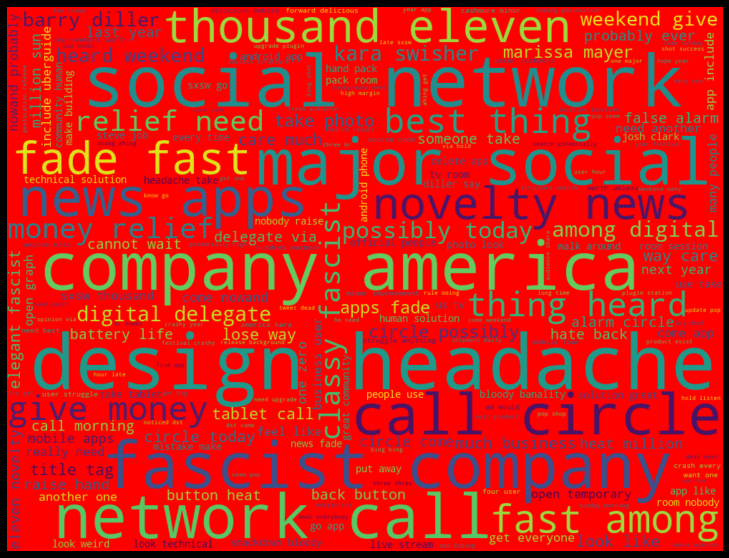

In [405]:
wordcloud = WordCloud(width=1000, height=760,min_word_length =3,
                      background_color='red')
wordcloud.generate_from_frequencies(frequencies=neg_bigrams)
plt.figure( figsize=(15,10),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [402]:
poz_bigrams = get_top_tfidf_bigrams(poz_corpus,100000)
poz_bigrams

{'social network': 0.27653733830498894,
 'marissa mayer': 0.1929330267244109,
 'network call': 0.18328637538819037,
 'call circle': 0.18328637538819037,
 'major social': 0.1736397240519698,
 'open pop': 0.16720862316115612,
 'open temporary': 0.15434642137952873,
 'even begin': 0.13183756826168078,
 'possibly today': 0.13183756826168078,
 'circle possibly': 0.12862201781627394,
 'temporary downtown': 0.12219091692546025,
 'begin win': 0.12219091692546025,
 'come cool': 0.11575981603464655,
 'cool technology': 0.10932871514383286,
 'one ever': 0.10932871514383286,
 'go conference': 0.10932871514383286,
 'technology one': 0.10289761425301915,
 'heard go': 0.10289761425301915,
 'pop shop': 0.0996820638076123,
 'ever heard': 0.0996820638076123,
 'six th': 0.08360431158057806,
 'one hundred': 0.08360431158057806,
 'rumor open': 0.08038876113517121,
 'route around': 0.07717321068976436,
 'set open': 0.07395766024435751,
 'give away': 0.07395766024435751,
 'marketing expert': 0.07074210979895

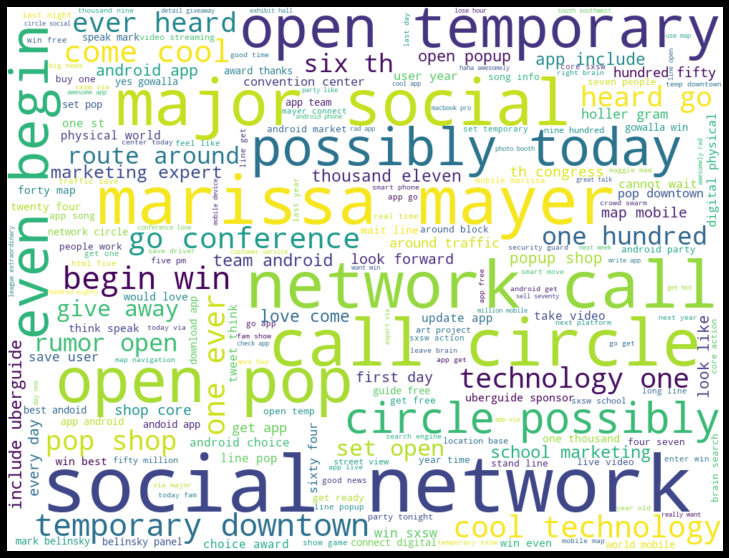

In [407]:
wordcloud = WordCloud(width=1000, height=760,min_word_length =4,
                      background_color='white')
wordcloud.generate_from_frequencies(frequencies=poz_bigrams)
plt.figure( figsize=(20,10),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


It's interesting to look at the dataset and see how similar the top words using both frequency and tfidf are for the different sentiments. They are close, it will be challenging to get the models to recognize the differences in the sentiments.

## EDA Assessments

The dataset presents processing challenges. I am allowing misspellings and abbreviations as the wordclouds revealed enough differences in the dataset for modeling. There is a lot of overlap in the wordclouds and frequencies, but there is also many differences. Removing observations will help the modeling process. There is a negative sentiment towards some apple products, but those may be balanced by positive feelings as well. 

The challenges to machine learning with NLP are certainly a preprocessing struggle as much as a struggle with any other portion of the work. It is fascinating to see the phrases that bubble up, particulary the negative phrases. 